In [2]:
import pymongo as pm
import ssl, certifi
from datetime import datetime, timedelta, timezone
import numpy as np
import matplotlib.pyplot as plt

In [3]:
USER = "ictts"
PWD  = "Ict4SM22!"
HOST = "bigdatadb.polito.it"
PORT = 27017
DB   = "carsharing"

client = pm.MongoClient(HOST,
ssl=True, #there might be conflicts, try to set to False
authSource = DB,
username = USER,
password =PWD,
port=PORT,
tlsAllowInvalidCertificates=True)

db = client[DB]
db.list_collection_names()

['enjoy_DebugInfo',
 'ictts_PermanentBookings',
 'ictts_enjoy_PermanentBookings',
 'enjoy_PermanentBookings',
 'BigDive7_PermanentBookings',
 'enjoy_ActiveParkings',
 'test_collection',
 'DebugInfo',
 'PermanentBookings',
 'PermanentParkings',
 'system.js',
 'ActiveParkings',
 'enjoy_PermanentParkings',
 'hexs_gen',
 'enjoy_ActiveBookings',
 'ActiveBookings']

**PART 1:**  
**Check if the booking records requires to be filtered to get valid rentals**

In [4]:
collections = ["ictts_PermanentBookings", "ictts_enjoy_PermanentBookings"]
city = "Torino"

In [5]:
# query to get the booking records in Turin and evaluate its duration by subtracting the start time from the end time
pipeline = [
    {
        "$match": {
            "city": city
        }
    },
    {
        "$project": {
            "init_loc": 1,
            "final_loc": 1,
            "duration": {
                "$subtract": ["$final_time", "$init_time"]
            }
        }
    }
]

car2go_booking_durations = list(db["ictts_PermanentBookings"].aggregate(pipeline))
enjoy_booking_durations = list(db["ictts_enjoy_PermanentBookings"].aggregate(pipeline))

booking_records = car2go_booking_durations + enjoy_booking_durations

print(f'BEFORE FILTERING:\nNumber of booking records: {len(booking_records)}')
print(f'Maximum booking duration (seconds): {max(record["duration"] for record in booking_records)}')
print(f'Minimum booking duration (seconds): {min(record["duration"] for record in booking_records)}')

# filter out records outside the 2 minutes and 1 hour range
booking_records = [record for record in booking_records if 120 <= record["duration"] <= 3600]

print(f'AFTER FILTERING:\nNumber of booking records AFTER filtering: {len(booking_records)}')
print(f'Maximum booking duration (seconds): {max(record["duration"] for record in booking_records)}')
print(f'Minimum booking duration (seconds): {min(record["duration"] for record in booking_records)}')

# print booking records structure
print(booking_records[0])

BEFORE FILTERING:
Number of booking records: 218840
Maximum booking duration (seconds): 3599
Minimum booking duration (seconds): 126
AFTER FILTERING:
Number of booking records AFTER filtering: 218840
Maximum booking duration (seconds): 3599
Minimum booking duration (seconds): 126
{'_id': ObjectId('5a3bb3af20c3dd47cf59003d'), 'final_loc': {'coordinates': [7.68634, 45.07567], 'type': 'Point'}, 'init_loc': {'coordinates': [7.68486, 45.08276], 'type': 'Point'}, 'duration': 1215}


/tmp/ipykernel_295/1970140351.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


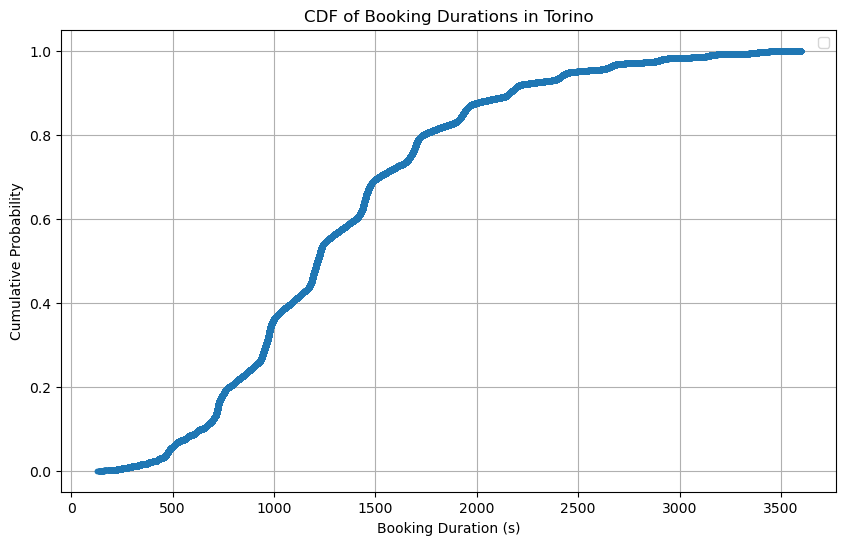

In [ ]:
# plot the CDF of the booking durations
plt.figure(figsize=(10,6))
plt.plot(np.sort([record['duration'] for record in booking_records]), np.linspace(0, 1, len(booking_records)), marker='.', linestyle='none')
plt.xlabel('Booking Duration (s)')
plt.ylabel('Cumulative Probability')
# plt.axvline(x=3600, color='r', linestyle='--', label='1 hour')
# plt.axvline(x=120, color='g', linestyle='--', label='2 minutes')
plt.title(f'CDF of Booking Durations in {city}')
plt.grid()
plt.legend()
plt.show()

The CDF of the durations of all the bookings in Torino shows no need to filter the records, since almost all the bookings have a duration in the outlier range used in the first lab [2 - 60 minutes].

**Derive the OD matrix based on the zones of Torino**  

Compares:  
- Weekdays (Monday to Friday) in day time (8am - 8pm) and Weekends (Saturday and Sunday) in day time (8am - 8pm)
- Car2go weekdays in day time vs Enjoy weekdays in day time

In [6]:
!pip install geojson
!pip install shapely

In [7]:
# query the db and create a dataframe mapping all the points to their zones
import geojson
import pandas as pd

with open(r"./Lab2/TorinoZonescol.geojson") as f:
    gj = geojson.load(f)

    zones = len(gj['features'])
    total_bookings = pd.DataFrame()

    for i in range(zones):
        for j in range(zones):
            zone_i = gj['features'][i]['geometry']['coordinates']
            zone_j = gj['features'][j]['geometry']['coordinates']

            pipeline = [
                {
                    "$match": {
                        "city": city,
                        "init_loc": {
                            "$geoWithin": {
                                "$geometry": {
                                    "type": "MultiPolygon",
                                    "coordinates": zone_i
                                }
                            }
                        },
                        "final_loc": {
                            "$geoWithin": {
                                "$geometry": {
                                    "type": "MultiPolygon",
                                    "coordinates": zone_j
                                }
                            }
                        }
                    }
                },
                {
                    "$project": {
                        "init_loc": 1,
                        "final_loc": 1,
                        "init_date": 1,
                        "final_date": 1,
                        "init_time": 1,
                        "final_time": 1,
                        "duration": {
                            "$subtract": ["$final_time", "$init_time"]
                        }
                    }
                },
                {
                    "$addFields": {
                        "zone_init": i,
                        "zone_final": j
                    }
                }
            ]

            car2go_bookings = list(db["ictts_PermanentBookings"].aggregate(pipeline))
            # convert to dataframe
            car2go_df = pd.DataFrame(car2go_bookings)
            # add service column
            car2go_df['service'] = 'car2go'
            enjoy_bookings = list(db["ictts_enjoy_PermanentBookings"].aggregate(pipeline))
            enjoy_df = pd.DataFrame(enjoy_bookings)
            enjoy_df['service'] = 'enjoy'

            total_bookings = pd.concat([total_bookings, car2go_df, enjoy_df], ignore_index=True)

In [8]:
total_bookings.head()

_id          final_date  \
0  5a3bb3af20c3dd47cf59bf70 2017-10-10 15:54:54   
1  5a3bb3af20c3dd47cf5925f0 2017-10-27 15:00:43   
2  5a3bb3af20c3dd47cf599f7b 2017-10-13 22:45:40   
3  5a3bb3b020c3dd47cf5aaf22 2017-09-09 22:13:50   
4  5a3bb3b020c3dd47cf5a7e0f 2017-09-16 08:07:39   

                                           final_loc     init_time  \
0  {'coordinates': [7.68711, 45.06589], 'type': '...  1.507643e+09   
1  {'coordinates': [7.66775, 45.07001], 'type': '...  1.509108e+09   
2  {'coordinates': [7.67999, 45.05962], 'type': '...  1.507926e+09   
3  {'coordinates': [7.68662, 45.06017], 'type': '...  1.504986e+09   
4  {'coordinates': [7.68419, 45.06067], 'type': '...  1.505542e+09   

                                            init_loc    final_time  \
0  {'coordinates': [7.67469, 45.07686], 'type': '...  1.507644e+09   
1  {'coordinates': [7.67485, 45.07696], 'type': '...  1.509109e+09   
2  {'coordinates': [7.67484, 45.07694], 'type': '...  1.507928e+09   
3  {'coordinates': [7.67665, 45.07671], 'type': '...  1.504988e+09   
4  {'coordinates': [7.67633, 45.0768], 'type': 'P...  1.505542e+09   

            init_date  duration  zone_init  zone_final service  
0 2017-10-10 15:39:16     938.0        0.0         0.0  car2go  
1 2017-10-27 14:41:13    1170.0        0.0         0.0  car2go  
2 2017-10-13 22:23:44    1316.0        0.0         0.0  car2go  
3 2017-09-09 21:35:32    2298.0        0.0         0.0  car2go  
4 2017-09-16 08:00:19     440.0        0.0         0.0  car2go

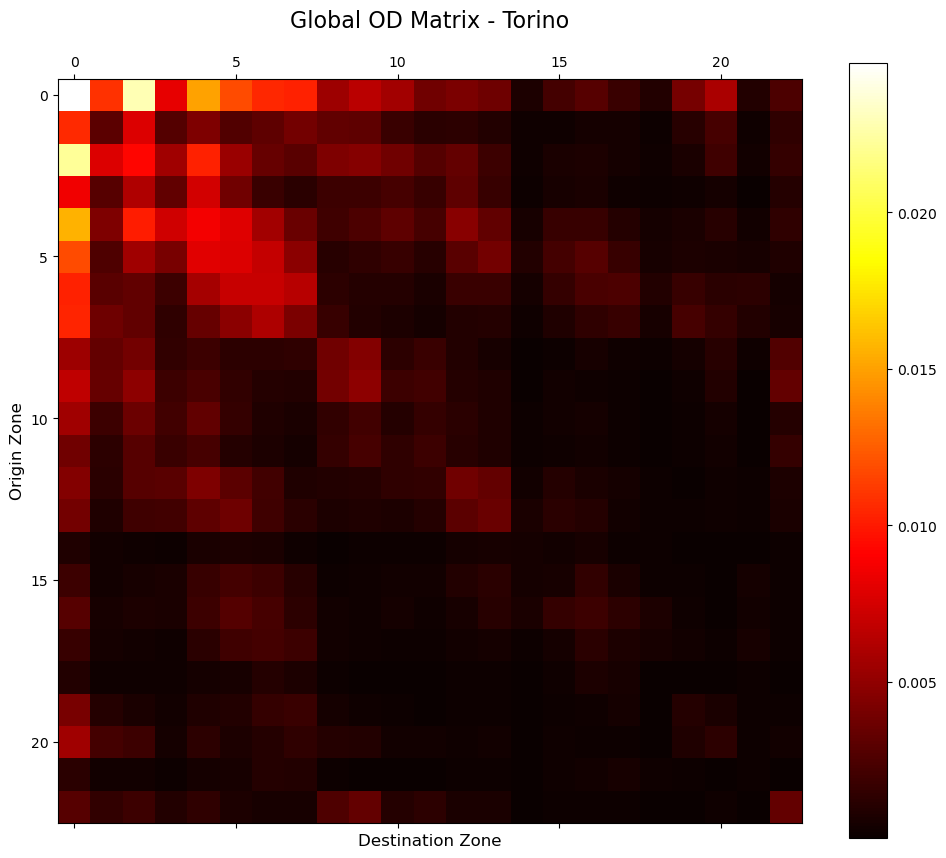

In [10]:
# create the global OD matrix
od_matrix = np.zeros((zones, zones))

for index, row in total_bookings.iterrows():
    zone_init = int(row['zone_init'])
    zone_final = int(row['zone_final'])
    od_matrix[zone_init][zone_final] += 1

# normalize the global OD matrix
od_matrix /= np.sum(od_matrix)

plt.figure(figsize=(12, 10))
cax = plt.matshow(od_matrix, cmap='hot', fignum=1)
plt.title(f'Global OD Matrix - {city}', fontsize=16, pad=20)
plt.xlabel('Destination Zone', fontsize=12)
plt.ylabel('Origin Zone', fontsize=12)
plt.colorbar(cax)
plt.show()

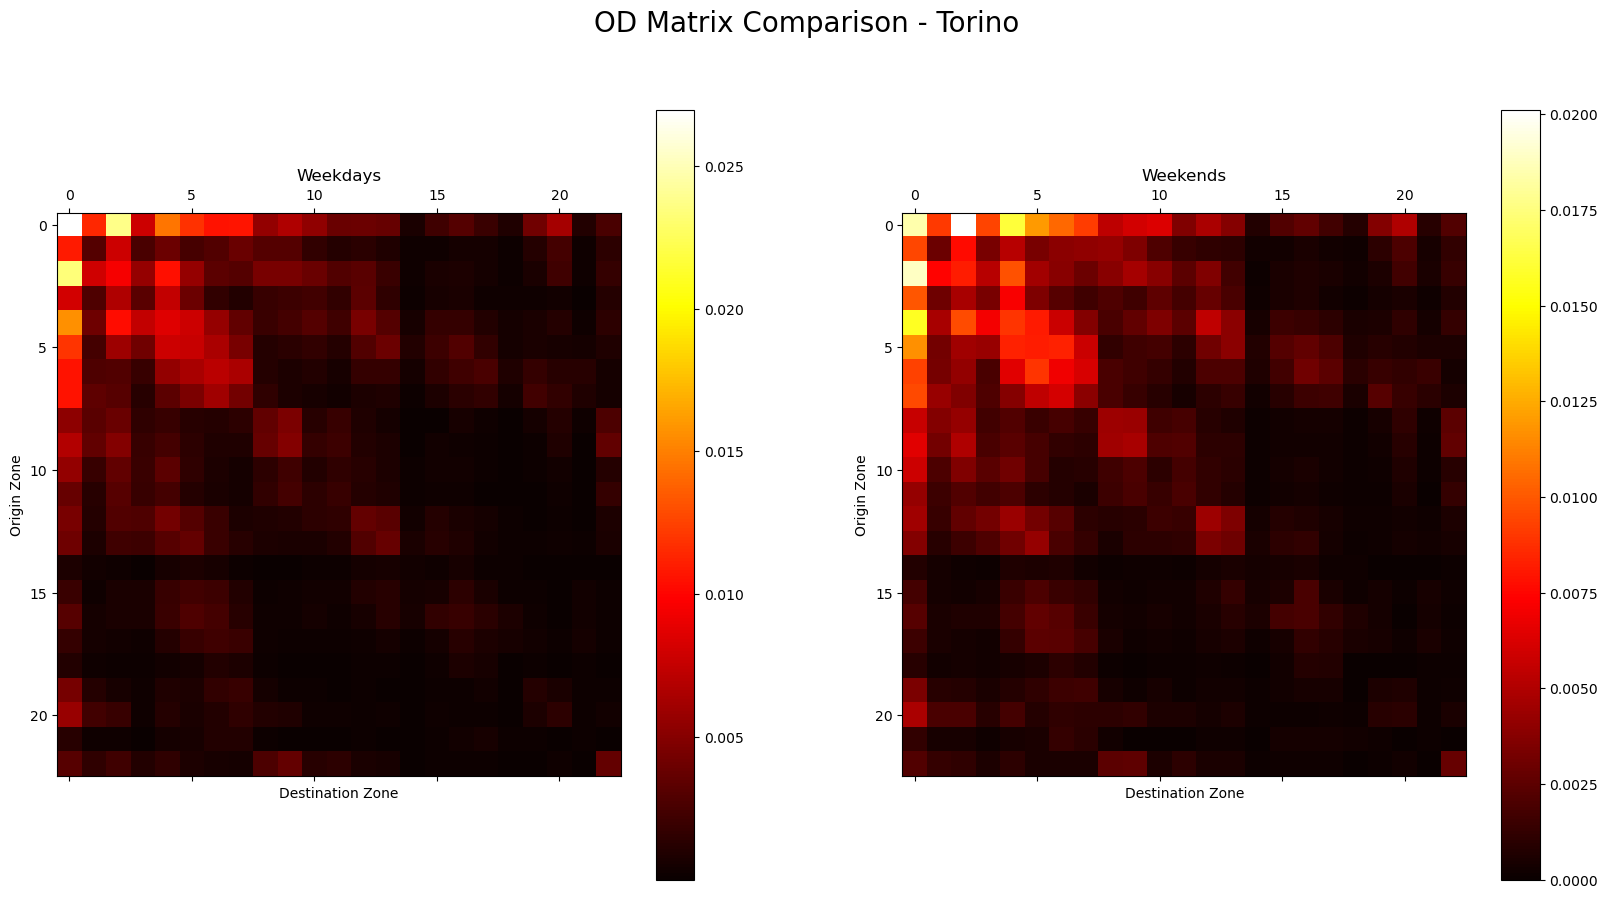

In [11]:
# create the OD matrix of bookings between zones, filter data per weekdays (Monday to Friday) and weekends (Saturday and Sunday)
od_matrix_weekday = np.zeros((zones, zones))
od_matrix_weekend = np.zeros((zones, zones))

for index, row in total_bookings.iterrows():
    init_date = row['init_date']
    zone_init = int(row['zone_init'])
    zone_final = int(row['zone_final'])

    # convert init_time to datetime object
    if init_date.weekday() < 5:  # Weekday
        od_matrix_weekday[zone_init][zone_final] += 1

    else:  # Weekend
        od_matrix_weekend[zone_init][zone_final] += 1

# normalize the OD matrices
od_matrix_weekday /= np.sum(od_matrix_weekday)
od_matrix_weekend /= np.sum(od_matrix_weekend)

# plot the OD matrices as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f'OD Matrix Comparison - {city}', fontsize=20)

titles = {
    'Weekdays': od_matrix_weekday,
    'Weekends': od_matrix_weekend
}

for ax, (title, matrix) in zip(axes.flatten(), titles.items()):
    cax = ax.matshow(matrix, cmap='hot')
    ax.set_title(title)
    ax.set_xlabel('Destination Zone')
    ax.set_ylabel('Origin Zone')
    fig.colorbar(cax, ax=ax)
plt.show()

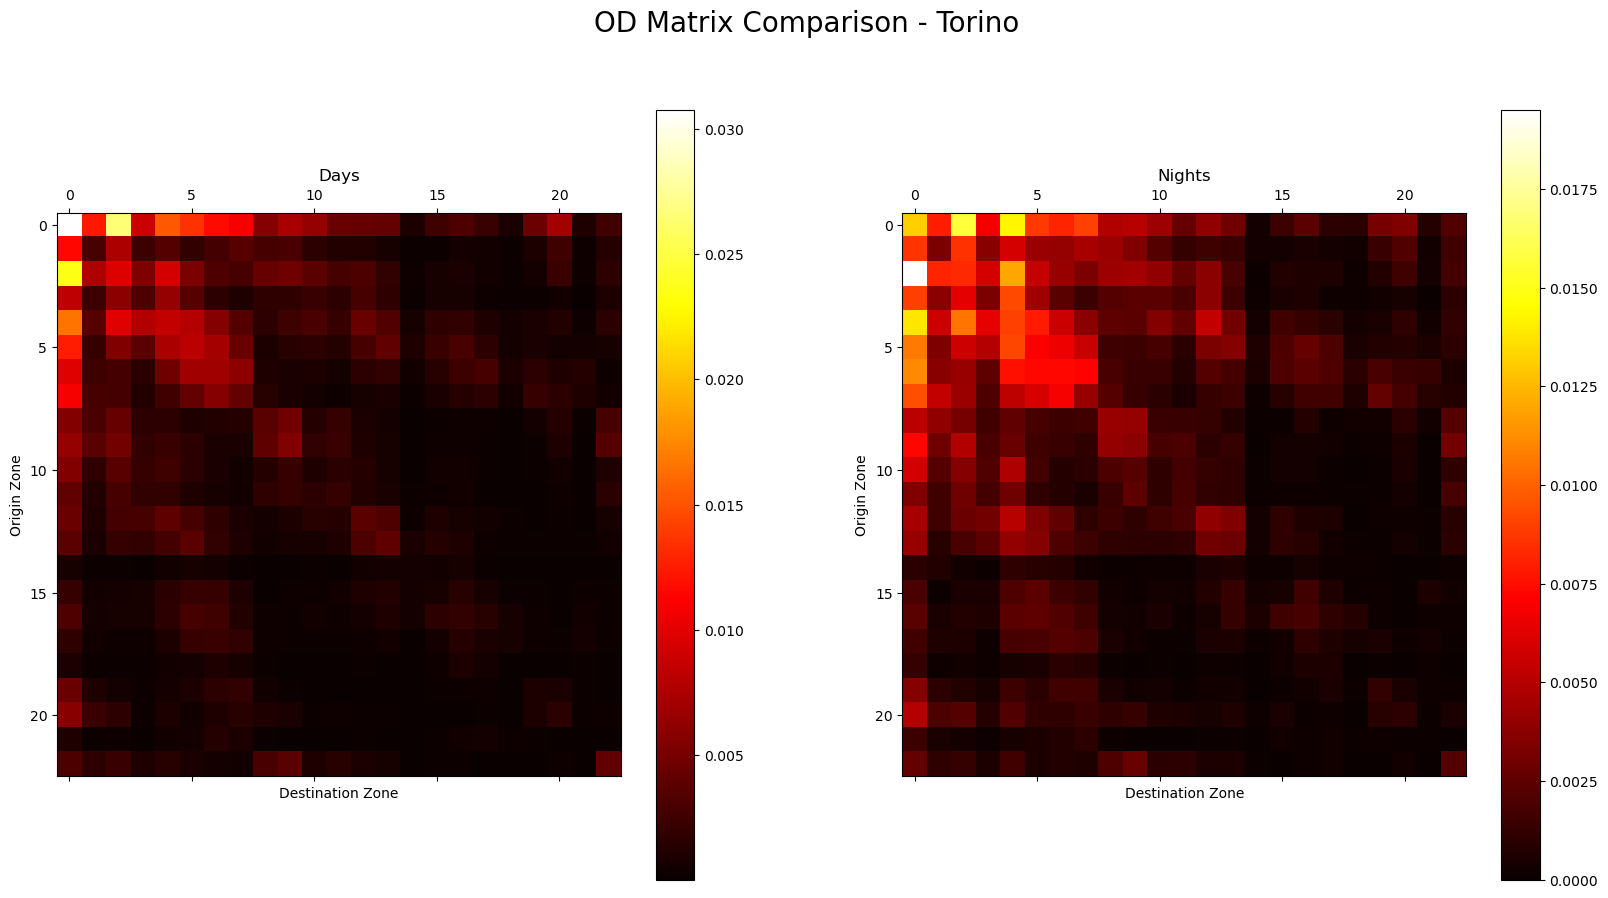

In [12]:
# create the OD matrix of bookings between zones, filter data per day hours (8 AM to 8PM) and night hours (8PM to 8AM)
od_matrix_day = np.zeros((zones, zones))
od_matrix_night = np.zeros((zones, zones))

for index, row in total_bookings.iterrows():
    init_date = row['init_date']
    zone_init = int(row['zone_init'])
    zone_final = int(row['zone_final'])

    # convert init_time to datetime object
    if 8 <= init_date.hour < 20:  # Day time
        od_matrix_day[zone_init][zone_final] += 1

    else:  # Weekend
        od_matrix_night[zone_init][zone_final] += 1

# normalize the OD matrices
od_matrix_day /= np.sum(od_matrix_day)
od_matrix_night /= np.sum(od_matrix_night)

# plot the OD matrices as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f'OD Matrix Comparison - {city}', fontsize=20)

titles = {
    'Days': od_matrix_day,
    'Nights': od_matrix_night
}

for ax, (title, matrix) in zip(axes.flatten(), titles.items()):
    cax = ax.matshow(matrix, cmap='hot')
    ax.set_title(title)
    ax.set_xlabel('Destination Zone')
    ax.set_ylabel('Origin Zone')
    fig.colorbar(cax, ax=ax)
plt.show()

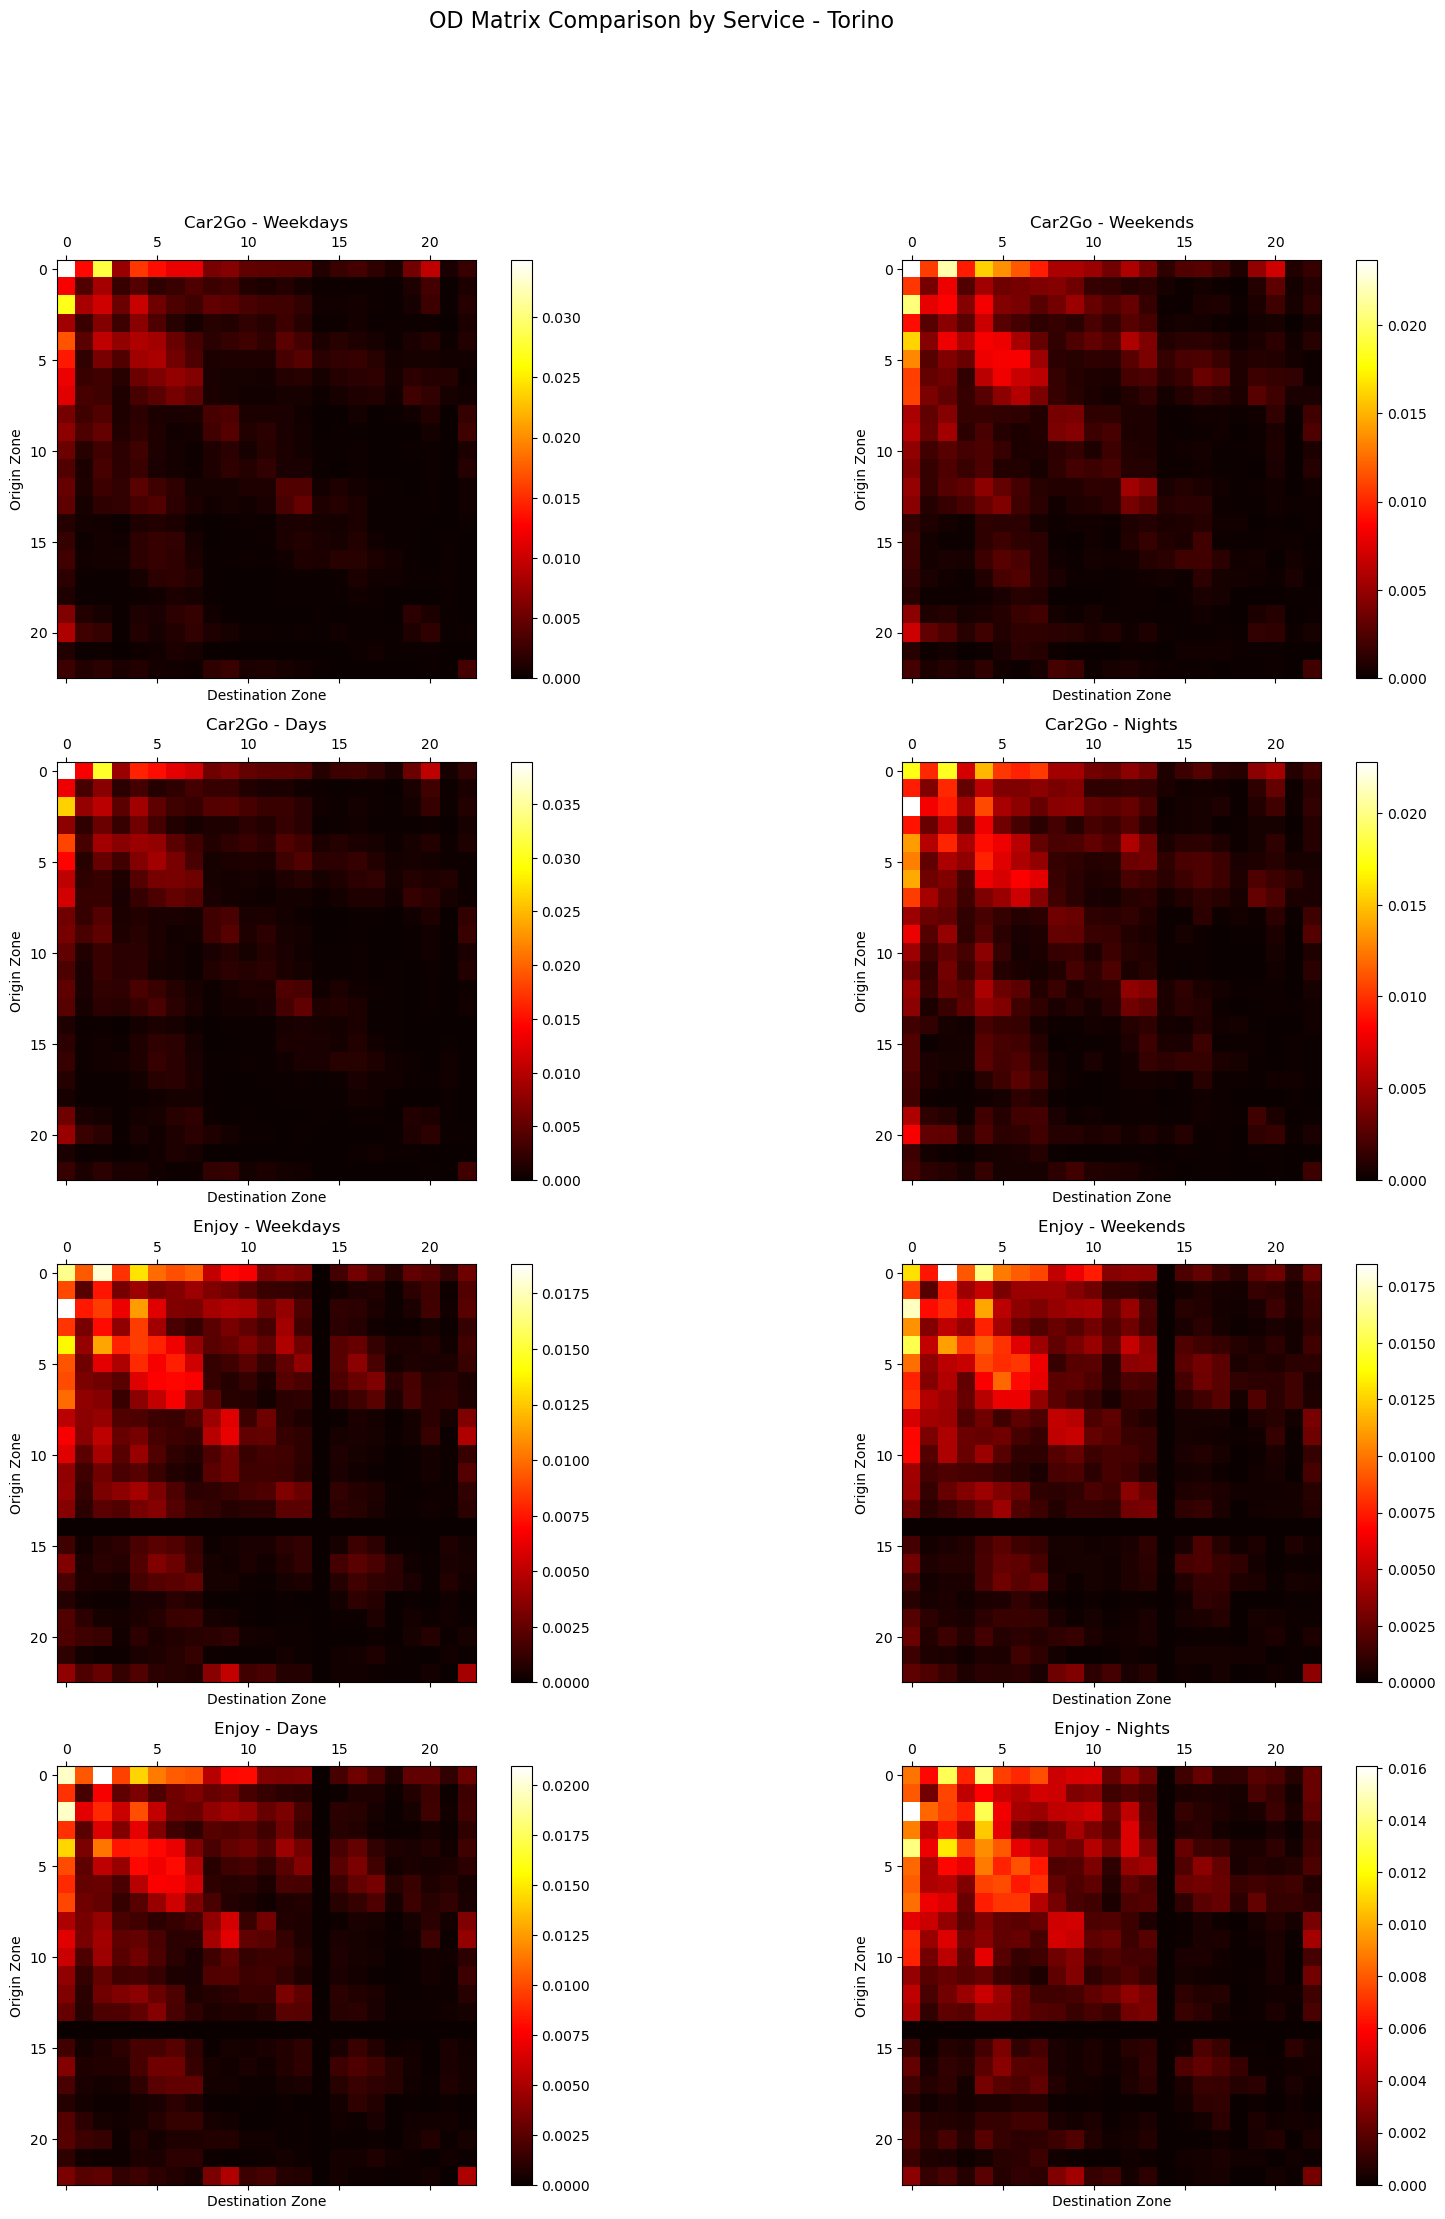

In [152]:
# create the OD matrix for the bookings of car2go and enjoy between zones
od_matrix_car2go_weekday = np.zeros((zones, zones))
od_matrix_car2go_weekend = np.zeros((zones, zones))
od_matrix_car2go_day = np.zeros((zones, zones))
od_matrix_car2go_night = np.zeros((zones, zones))

od_matrix_enjoy_weekday = np.zeros((zones, zones))
od_matrix_enjoy_weekend = np.zeros((zones, zones))
od_matrix_enjoy_day = np.zeros((zones, zones))
od_matrix_enjoy_night = np.zeros((zones, zones))

for index, row in total_bookings.iterrows():
    init_date = row['init_date']
    zone_init = int(row['zone_init'])
    zone_final = int(row['zone_final'])
    service = row['service']

    if service == 'car2go':
        # convert init_time to datetime object
        if init_date.weekday() < 5:  # Weekday
            od_matrix_car2go_weekday[zone_init][zone_final] += 1
        else:
            od_matrix_car2go_weekend[zone_init][zone_final] += 1

        if 8 <= init_date.hour < 20:  # Day time
            od_matrix_car2go_day[zone_init][zone_final] += 1
        else:  # Night time
            od_matrix_car2go_night[zone_init][zone_final] += 1

    elif service == 'enjoy':
        # convert init_time to datetime object
        if init_date.weekday() < 5:  # Weekday
            od_matrix_enjoy_weekday[zone_init][zone_final] += 1
        else:
            od_matrix_enjoy_weekend[zone_init][zone_final] += 1

        if 8 <= init_date.hour < 20:  # Day time
            od_matrix_enjoy_day[zone_init][zone_final] += 1
        else:  # Night time
            od_matrix_enjoy_night[zone_init][zone_final] += 1

# normalize the OD matrices
od_matrix_car2go_weekday /= np.sum(od_matrix_car2go_weekday)
od_matrix_car2go_weekend /= np.sum(od_matrix_car2go_weekend)
od_matrix_car2go_day /= np.sum(od_matrix_car2go_day)
od_matrix_car2go_night /= np.sum(od_matrix_car2go_night)

od_matrix_enjoy_weekday /= np.sum(od_matrix_enjoy_weekday)
od_matrix_enjoy_weekend /= np.sum(od_matrix_enjoy_weekend)
od_matrix_enjoy_day /= np.sum(od_matrix_enjoy_day)
od_matrix_enjoy_night /= np.sum(od_matrix_enjoy_night)

# plot the OD matrices as heatmaps
fig, axes = plt.subplots(4, 2, figsize=(20, 25))
fig.suptitle(f'OD Matrix Comparison by Service - {city}', fontsize=16)
titles = {
    'Car2Go - Weekdays': od_matrix_car2go_weekday,
    'Car2Go - Weekends': od_matrix_car2go_weekend,
    'Car2Go - Days': od_matrix_car2go_day,
    'Car2Go - Nights': od_matrix_car2go_night,
    'Enjoy - Weekdays': od_matrix_enjoy_weekday,
    'Enjoy - Weekends': od_matrix_enjoy_weekend,
    'Enjoy - Days': od_matrix_enjoy_day,
    'Enjoy - Nights': od_matrix_enjoy_night,
}
for ax, (title, matrix) in zip(axes.flatten(), titles.items()):
    cax = ax.matshow(matrix, cmap='hot')
    ax.set_title(title)
    ax.set_xlabel('Destination Zone')
    ax.set_ylabel('Origin Zone')
    fig.colorbar(cax, ax=ax)
plt.show()

In [14]:
print("Date range in total_bookings:")
print(f"Min date: {total_bookings['init_date'].min()}")
print(f"Max date: {total_bookings['init_date'].max()}")

Date range in total_bookings:
Min date: 2017-09-01 00:00:03
Max date: 2017-10-31 23:59:30


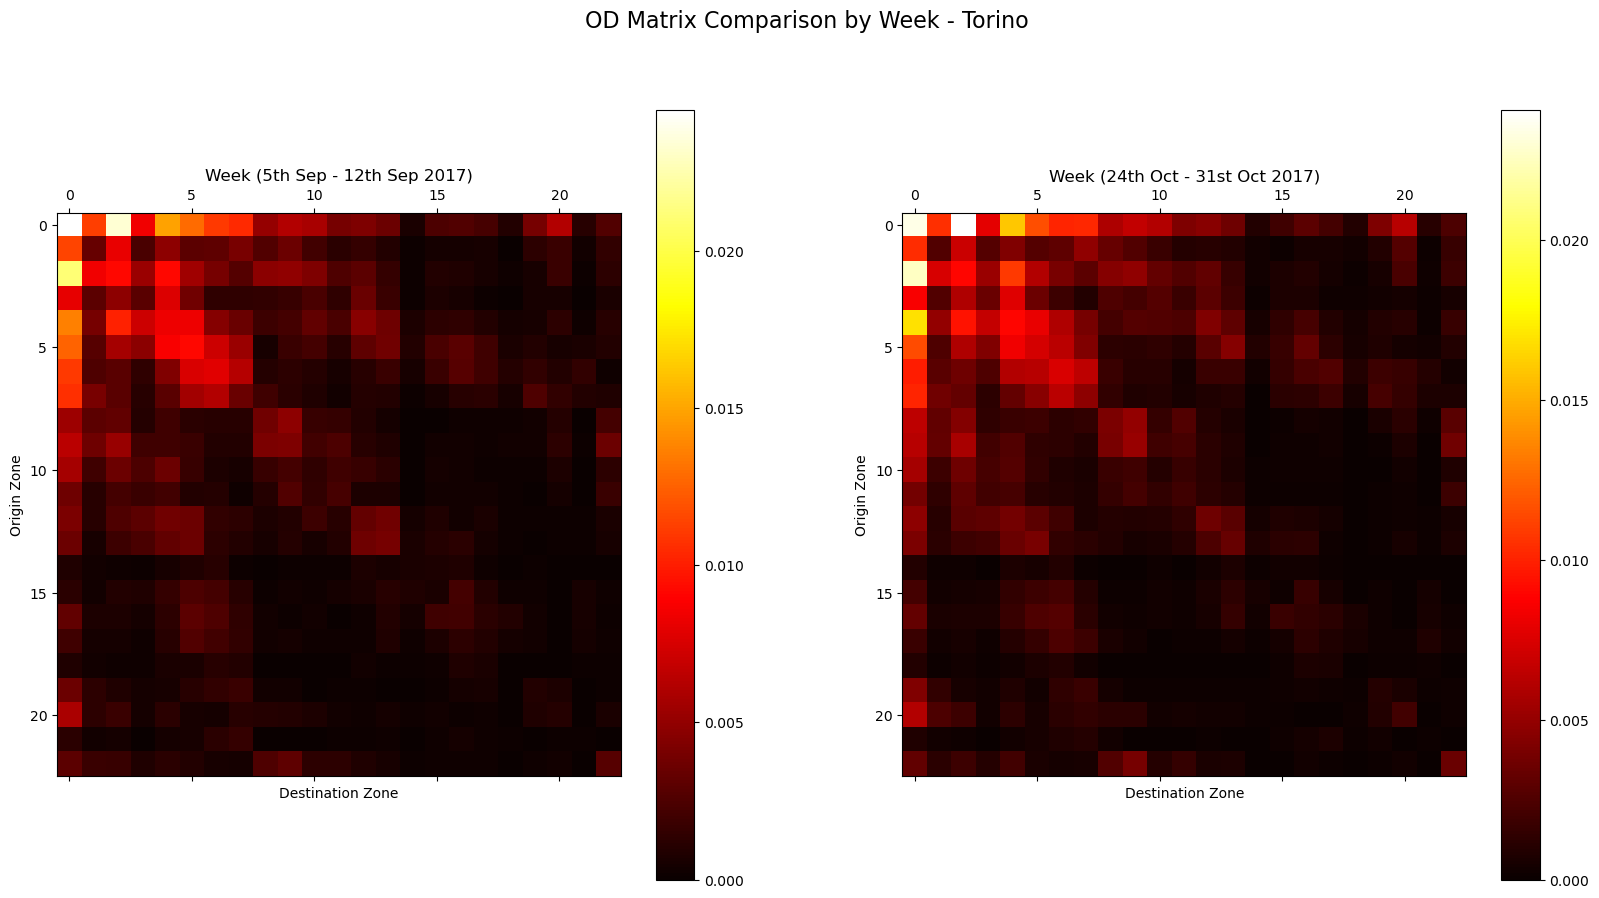

In [15]:
# evaluate the OD matrix for the bookings in different weeks of the dataset

# week1 : from 5th Sep 2017 to 12th Sep 2017
# week2 : from 24th Oct 2017 to 31st Oct 2017

od_matrix_week1 = np.zeros((zones, zones))
od_matrix_week2 = np.zeros((zones, zones))

for index, row in total_bookings.iterrows():
    init_date = row['init_date']
    zone_init = int(row['zone_init'])
    zone_final = int(row['zone_final'])

    if datetime(2017, 9, 5) <= init_date < datetime(2017, 9, 12):
        od_matrix_week1[zone_init][zone_final] += 1
    elif datetime(2017, 10, 24) <= init_date < datetime(2017, 10, 31):
        od_matrix_week2[zone_init][zone_final] += 1    

# normalize the OD matrices
od_matrix_week1 /= np.sum(od_matrix_week1)
od_matrix_week2 /= np.sum(od_matrix_week2)

# plot the OD matrices as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f'OD Matrix Comparison by Week - {city}', fontsize=16)
titles = {
    'Week (5th Sep - 12th Sep 2017)': od_matrix_week1,
    'Week (24th Oct - 31st Oct 2017)': od_matrix_week2
}
for ax, (title, matrix) in zip(axes.flatten(), titles.items()):
    cax = ax.matshow(matrix, cmap='hot')
    ax.set_title(title)
    ax.set_xlabel('Destination Zone')
    ax.set_ylabel('Origin Zone')
    fig.colorbar(cax, ax=ax)
plt.show()

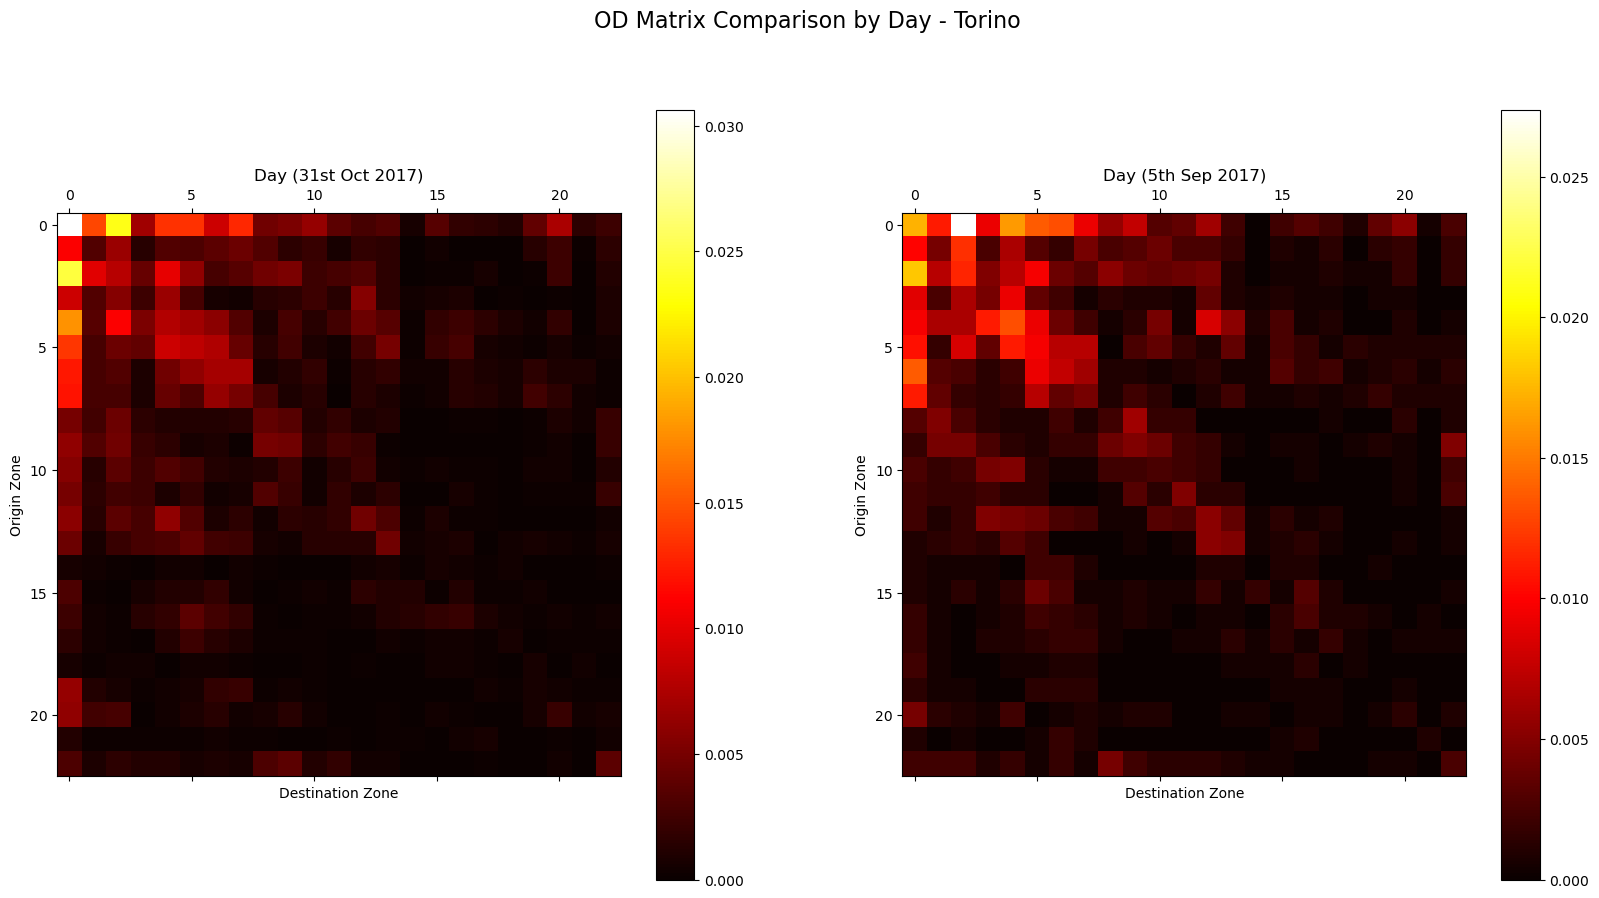

In [16]:
# evaluate the OD matrix for the bookings in different days

# day1 : 31st Oct 2017
# day2 : 5st Sep 2017

od_matrix_day1 = np.zeros((zones, zones))
od_matrix_day2 = np.zeros((zones, zones))

for index, row in total_bookings.iterrows():
    init_date = row['init_date']
    zone_init = int(row['zone_init'])
    zone_final = int(row['zone_final'])

    if init_date.date() == datetime(2017, 10, 31).date():
        od_matrix_day1[zone_init][zone_final] += 1
    elif init_date.date() == datetime(2017, 9, 5).date():
        od_matrix_day2[zone_init][zone_final] += 1

# normalize the OD matrices
od_matrix_day1 /= np.sum(od_matrix_day1)
od_matrix_day2 /= np.sum(od_matrix_day2)

# plot the OD matrices as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f'OD Matrix Comparison by Day - {city}', fontsize=16)
titles = {
    'Day (31st Oct 2017)': od_matrix_day1,
    'Day (5th Sep 2017)': od_matrix_day2
}
for ax, (title, matrix) in zip(axes.flatten(), titles.items()):
    cax = ax.matshow(matrix, cmap='hot')
    ax.set_title(title)
    ax.set_xlabel('Destination Zone')
    ax.set_ylabel('Origin Zone')
    fig.colorbar(cax, ax=ax)
plt.show()

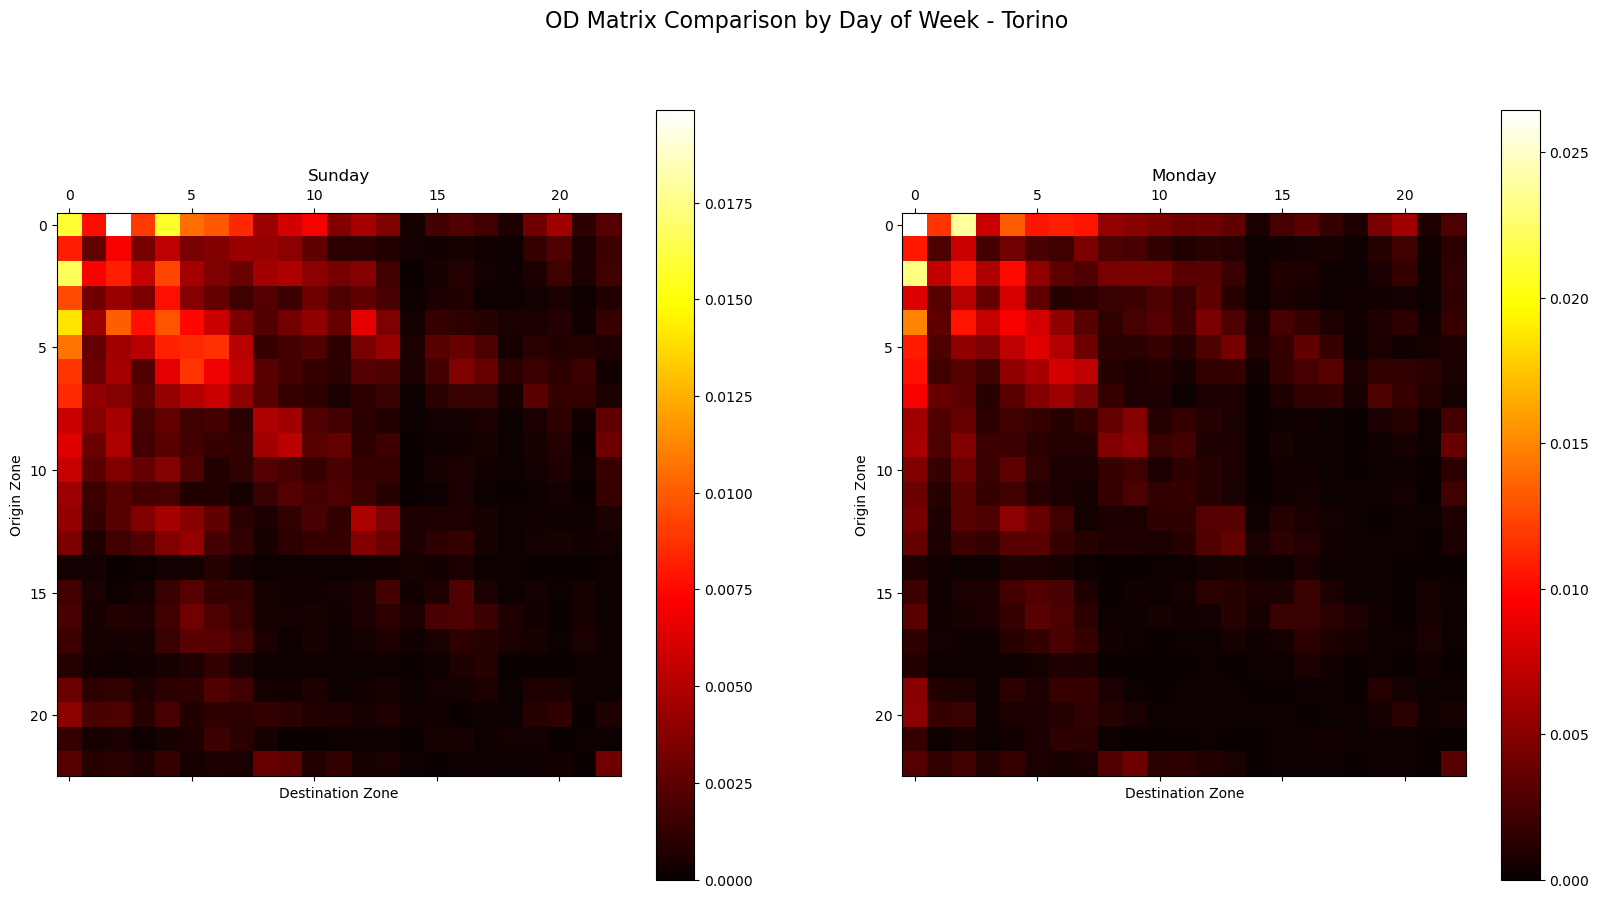

In [17]:
# evaluate the OD matrix for the bookings in Sundays vs Mondays

od_matrix_sunday = np.zeros((zones, zones))
od_matrix_monday = np.zeros((zones, zones))

for index, row in total_bookings.iterrows():
    init_date = row['init_date']
    zone_init = int(row['zone_init'])
    zone_final = int(row['zone_final'])

    if init_date.weekday() == 6:  # Sunday
        od_matrix_sunday[zone_init][zone_final] += 1
    elif init_date.weekday() == 0:  # Monday
        od_matrix_monday[zone_init][zone_final] += 1
# normalize the OD matrices
od_matrix_sunday /= np.sum(od_matrix_sunday)
od_matrix_monday /= np.sum(od_matrix_monday)

# plot the OD matrices as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f'OD Matrix Comparison by Day of Week - {city}', fontsize=16)
titles = {
    'Sunday': od_matrix_sunday,
    'Monday': od_matrix_monday
}
for ax, (title, matrix) in zip(axes.flatten(), titles.items()):
    cax = ax.matshow(matrix, cmap='hot')
    ax.set_title(title)
    ax.set_xlabel('Destination Zone')
    ax.set_ylabel('Origin Zone')
    fig.colorbar(cax, ax=ax)
plt.show()

Plot the geojson of the zones of Torino

In [ ]:
!pip install contextily

  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl.metadata (4.8 kB)
  Using cached rasterio-1.4.3-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
  Using cached geographiclib-2.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl.metadata (6.5 kB)
Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
Using cached geographiclib-2.1-py3-none-any.whl (40 kB)
Using cached mercantile-1.2.1-py3-none-any.whl (14 kB)
Using cached rasterio-1.4.3-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (22.2 MB)
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
Using cached affine-2.4.0-py3-none-any.whl (15 kB)
Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [contextily]8 [geopy]i

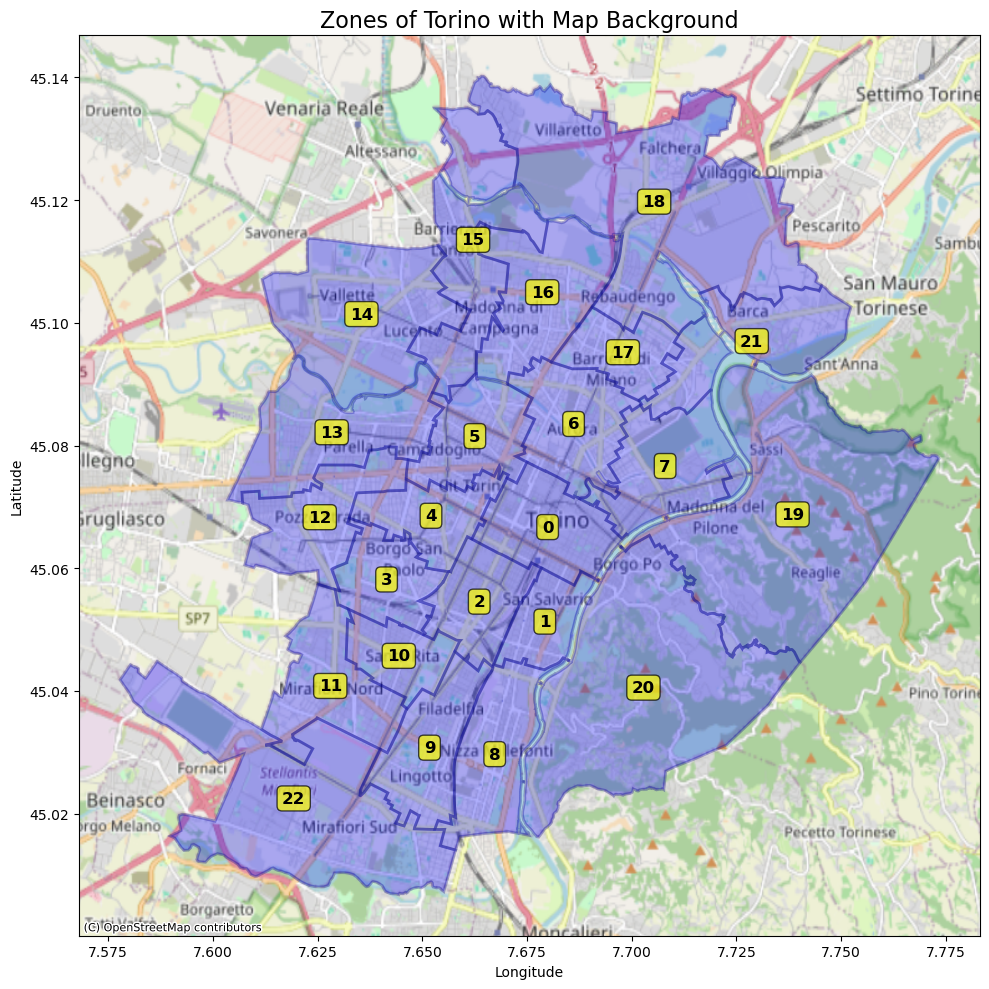

In [ ]:
# plot the zones of the geojson file with map background and zone numbers

import matplotlib.pyplot as plt
from shapely.geometry import shape
import contextily as ctx

fig, ax = plt.subplots(figsize=(10, 10))

# Plot each zone
for idx, feature in enumerate(gj['features']):
    geom = shape(feature['geometry'])

    if geom.geom_type == 'Polygon':
        x, y = geom.exterior.xy
        ax.fill(x, y, alpha=0.3, fc='blue', ec='darkblue', linewidth=2)
        # Calculate centroid for zone number
        centroid = geom.centroid
        ax.text(centroid.x, centroid.y, str(idx), fontsize=12,
                ha='center', va='center', weight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

    elif geom.geom_type == 'MultiPolygon':
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            ax.fill(x, y, alpha=0.3, fc='blue', ec='darkblue', linewidth=2)
        # Calculate centroid for zone number
        centroid = geom.centroid
        ax.text(centroid.x, centroid.y, str(idx), fontsize=12,
                ha='center', va='center', weight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.set_title('Zones of Torino with Map Background', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add basemap (OpenStreetMap)
try:
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
except:
    print("Could not load basemap. Install contextily: pip install contextily")

plt.tight_layout()
plt.show()

**Derive metrics to compute similarity between the OD matrices**

In [19]:
# compute the distance between matrices by using Manhattan, Euclidean, maximum distance, spetral norm

def manhattan_distance(mat1, mat2):
    return np.sum(np.abs(mat1 - mat2))

def euclidean_distance(mat1, mat2):
    return np.sqrt(np.sum((mat1 - mat2) ** 2))

def maximum_distance(mat1, mat2):
    return np.max(np.abs(mat1 - mat2))

def spectral_distance(mat1, mat2):
    return np.linalg.norm(mat1 - mat2, 2)

# evaluate distances between weekdays and weekends
print("Distances between Weekday and Weekend OD Matrices:")
print(f"Manhattan Distance: {manhattan_distance(od_matrix_weekday, od_matrix_weekend)}")
print(f"Euclidean Distance: {euclidean_distance(od_matrix_weekday, od_matrix_weekend)}")
print(f"Maximum Distance: {maximum_distance(od_matrix_weekday, od_matrix_weekend)}")
print(f"Spectral Distance: {spectral_distance(od_matrix_weekday, od_matrix_weekend)}")

# evaluate distances between days and nights
print("\nDistances between Day Time (8am - 8pm) and Night Time (8pm - 8am) OD Matrices:")
print(f"Manhattan Distance: {manhattan_distance(od_matrix_day, od_matrix_night)}")
print(f"Euclidean Distance: {euclidean_distance(od_matrix_day, od_matrix_night)}")
print(f"Maximum Distance: {maximum_distance(od_matrix_day, od_matrix_night)}")
print(f"Spectral Distance: {spectral_distance(od_matrix_day, od_matrix_night)}")

# evaluate distances between car2go and enjoy matrices
print("\nDistances between Car2Go and Enjoy OD Matrices during Weekday :")
print(f"Manhattan Distance: {manhattan_distance(od_matrix_car2go_weekday, od_matrix_enjoy_weekday)}")
print(f"Euclidean Distance: {euclidean_distance(od_matrix_car2go_weekday, od_matrix_enjoy_weekday)}")
print(f"Maximum Distance: {maximum_distance(od_matrix_car2go_weekday, od_matrix_enjoy_weekday)}")
print(f"Spectral Distance: {spectral_distance(od_matrix_car2go_weekday, od_matrix_enjoy_weekday)}")

print("\nDistances between Car2Go and Enjoy OD Matrices during Weekend")
print(f"Manhattan Distance: {manhattan_distance(od_matrix_car2go_weekend, od_matrix_enjoy_weekend)}")
print(f"Euclidean Distance: {euclidean_distance(od_matrix_car2go_weekend, od_matrix_enjoy_weekend)}")
print(f"Maximum Distance: {maximum_distance(od_matrix_car2go_weekend, od_matrix_enjoy_weekend)}")
print(f"Spectral Distance: {spectral_distance(od_matrix_car2go_weekend, od_matrix_enjoy_weekend)}")

print("\nDistances between Car2Go and Enjoy OD Matrices during Day Time (8am - 8pm):")
print(f"Manhattan Distance: {manhattan_distance(od_matrix_car2go_day, od_matrix_enjoy_day)}")
print(f"Euclidean Distance: {euclidean_distance(od_matrix_car2go_day, od_matrix_enjoy_day)}")
print(f"Maximum Distance: {maximum_distance(od_matrix_car2go_day, od_matrix_enjoy_day)}")
print(f"Spectral Distance: {spectral_distance(od_matrix_car2go_day, od_matrix_enjoy_day)}")

print("\nDistances between Car2Go and Enjoy OD Matrices during Weekend Night Time (8am - 8pm):")
print(f"Manhattan Distance: {manhattan_distance(od_matrix_car2go_night, od_matrix_enjoy_night)}")
print(f"Euclidean Distance: {euclidean_distance(od_matrix_car2go_night, od_matrix_enjoy_night)}")
print(f"Maximum Distance: {maximum_distance(od_matrix_car2go_night, od_matrix_enjoy_night)}")
print(f"Spectral Distance: {spectral_distance(od_matrix_car2go_night, od_matrix_enjoy_night)}")

# evaluate distances between week1 and week2 matrices
print("\nDistances between Week (5th Sep - 12th Sep 2017) and Week (24th Oct - 31st Oct 2017) OD Matrices:")
print(f"Manhattan Distance: {manhattan_distance(od_matrix_week1, od_matrix_week2)}")
print(f"Euclidean Distance: {euclidean_distance(od_matrix_week1, od_matrix_week2)}")
print(f"Maximum Distance: {maximum_distance(od_matrix_week1, od_matrix_week2)}")
print(f"Spectral Distance: {spectral_distance(od_matrix_week1, od_matrix_week2)}")

# evaluate distances between day1 and day2 matrices
print("\nDistances between Day (31st Oct 2017) and Day (5th Sep 2017) OD Matrices:")
print(f"Manhattan Distance: {manhattan_distance(od_matrix_day1, od_matrix_day2)}")
print(f"Euclidean Distance: {euclidean_distance(od_matrix_day1, od_matrix_day2)}")
print(f"Maximum Distance: {maximum_distance(od_matrix_day1, od_matrix_day2)}")
print(f"Spectral Distance: {spectral_distance(od_matrix_day1, od_matrix_day2)}")

# evaluate distances between Sundays and Mondays matrices
print("\nDistances between Sunday and Monday OD Matrices:")
print(f"Manhattan Distance: {manhattan_distance(od_matrix_sunday, od_matrix_monday)}")
print(f"Euclidean Distance: {euclidean_distance(od_matrix_sunday, od_matrix_monday)}")
print(f"Maximum Distance: {maximum_distance(od_matrix_sunday, od_matrix_monday)}")
print(f"Spectral Distance: {spectral_distance(od_matrix_sunday, od_matrix_monday)}")

Distances between Weekday and Weekend OD Matrices:
Manhattan Distance: 0.15145756691162748
Euclidean Distance: 0.014211273817640407
Maximum Distance: 0.008511036041640434
Spectral Distance: 0.01149889319448949

Distances between Day Time (8am - 8pm) and Night Time (8pm - 8am) OD Matrices:
Manhattan Distance: 0.24667445086362086
Euclidean Distance: 0.02697911490721545
Maximum Distance: 0.017631927093616155
Spectral Distance: 0.02361760277286178

Distances between Car2Go and Enjoy OD Matrices during Weekday :
Manhattan Distance: 0.3214346347888978
Euclidean Distance: 0.030649313364862766
Maximum Distance: 0.018173906516882374
Spectral Distance: 0.02678788978383626

Distances between Car2Go and Enjoy OD Matrices during Weekend
Manhattan Distance: 0.2832921889898786
Euclidean Distance: 0.0217703788558552
Maximum Distance: 0.01072049048289721
Spectral Distance: 0.016915129693965407

Distances between Car2Go and Enjoy OD Matrices during Day Time (8am - 8pm):
Manhattan Distance: 0.30738963733

Task 3 : Compute OD matrices using Unipoltech DS and IMQ  and estimate the similarity using the metrics drived in Task 2 .

In [20]:
!pip install geopandas

  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached pyogrio-0.12.1-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached pyproj-3.7.2-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (31 kB)
Using cached geopandas-1.1.1-py3-none-any.whl (338 kB)
Using cached pyogrio-0.12.1-cp313-cp313-manylinux_2_28_x86_64.whl (32.5 MB)
Using cached pyproj-3.7.2-cp313-cp313-manylinux_2_28_x86_64.whl (9.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [geopandas]/3 [geopandas]


In [21]:
from shapely.geometry import Point, MultiPolygon, Polygon
import geopandas as gpd
import seaborn as sns
import math as mt
import pandas as pd


In [26]:
trip_file =  "./Lab2/Trips_OD_TO.csv"
info_file = "./Lab2/Info_TO.csv"
zones_file = "./Lab2/TorinoZonescol.geojson"

In [27]:
# make each file a DF
df_trips = pd.read_csv(trip_file, sep=",")
df_info  = pd.read_csv(info_file, sep=",")
with open(zones_file) as f:
    gj = geojson.load(f)

In [28]:
# make zones out of geojson data
multipolygons = []
zones_id = []

for i, feature in enumerate(gj["features"]):
    polygons = [Polygon(polygon_coords[0]) for polygon_coords in feature["geometry"]["coordinates"]]
    multipolygons.append(MultiPolygon(polygons))
    zones_id.append(f"Q{i + 1:03d}") # Q001, Q002, ...


gdf_zones = gpd.GeoDataFrame({'zone_id': zones_id, 'geometry': multipolygons})
gdf_zones.set_crs(epsg=4326, inplace=True)

zone_id                                           geometry
0     Q001  MULTIPOLYGON (((7.69186 45.07049, 7.6915 45.06...
1     Q002  MULTIPOLYGON (((7.67494 45.04515, 7.67417 45.0...
2     Q003  MULTIPOLYGON (((7.66865 45.06233, 7.67018 45.0...
3     Q004  MULTIPOLYGON (((7.64158 45.05197, 7.64313 45.0...
4     Q005  MULTIPOLYGON (((7.65479 45.07331, 7.65583 45.0...
5     Q006  MULTIPOLYGON (((7.66296 45.09101, 7.66299 45.0...
6     Q007  MULTIPOLYGON (((7.67953 45.07582, 7.6795 45.07...
7     Q008  MULTIPOLYGON (((7.69869 45.06555, 7.69772 45.0...
8     Q009  MULTIPOLYGON (((7.66486 45.01675, 7.66402 45.0...
9     Q010  MULTIPOLYGON (((7.65796 45.01958, 7.65798 45.0...
10    Q011  MULTIPOLYGON (((7.63863 45.05135, 7.64001 45.0...
11    Q012  MULTIPOLYGON (((7.62981 45.05417, 7.62985 45.0...
12    Q013  MULTIPOLYGON (((7.60898 45.06395, 7.60938 45.0...
13    Q014  MULTIPOLYGON (((7.62536 45.07682, 7.62489 45.0...
14    Q015  MULTIPOLYGON (((7.64647 45.0954, 7.649 45.0947...
15    Q016  MULTIPOLYGON (((7.65681 45.13478, 7.65733 45.1...
16    Q017  MULTIPOLYGON (((7.68787 45.11637, 7.68807 45.1...
17    Q018  MULTIPOLYGON (((7.69806 45.09888, 7.69834 45.0...
18    Q019  MULTIPOLYGON (((7.70626 45.11102, 7.7059 45.11...
19    Q020  MULTIPOLYGON (((7.74543 45.04889, 7.74308 45.0...
20    Q021  MULTIPOLYGON (((7.71236 45.05663, 7.71246 45.0...
21    Q022  MULTIPOLYGON (((7.72181 45.10454, 7.7221 45.10...
22    Q023  MULTIPOLYGON (((7.59185 45.04246, 7.59258 45.0...

In [29]:
# Add gender from the info file to each row of the df_trips
df_trips = df_trips.merge(df_info[['id_veicolo', 'genere']], on='id_veicolo', how='left')


# GeoDataFrames start => each row is a start point
gdf_trips_start = gpd.GeoDataFrame(df_trips, geometry=gpd.points_from_xy(df_trips['lon_start'], df_trips['lat_start'])) #merge lon and lat to make one point for each trip

# GeoDataFrames stop => each row is a stop point
gdf_trips_stop = gpd.GeoDataFrame(df_trips, geometry=gpd.points_from_xy(df_trips['lon_stop'], df_trips['lat_stop']))

In [30]:
# spatial reference system => does not convert coordinates, just labels them
# necessary for spatial operations like join or within
gdf_trips_start.set_crs(epsg=4326, inplace=True)
gdf_trips_stop.set_crs(epsg=4326, inplace=True)

id_veicolo  id_viaggio        istante_start  lat_start  lon_start  \
0                1           2  2024-08-27 21:15:03     45.069      7.698   
1                1           4  2024-08-27 21:22:47     45.069      7.698   
2                1           5  2024-08-28 08:16:42     45.083      7.675   
3                1           6  2024-08-28 11:47:37     45.068      7.687   
4                1           7  2024-08-29 12:22:22     45.083      7.675   
...            ...         ...                  ...        ...        ...   
545377       37949          17  2024-09-02 14:11:20     45.076      7.682   
545378       37949          19  2024-09-02 14:49:10     45.072      7.602   
545379       37949          26  2024-09-03 13:20:06     45.076      7.682   
545380       37949          28  2024-09-03 13:24:11     45.076      7.681   
545381       37949          29  2024-09-03 15:00:06     45.067      7.578   

               istante_stop  lat_stop  lon_stop genere              geometry  
0       2024-08-27 21:16:05    45.069     7.698      M  POINT (7.698 45.069)  
1       2024-08-27 21:32:03    45.083     7.675      M  POINT (7.675 45.083)  
2       2024-08-28 08:29:07    45.067     7.688      M  POINT (7.688 45.067)  
3       2024-08-28 11:54:02    45.083     7.675      M  POINT (7.675 45.083)  
4       2024-08-29 12:31:44    45.077     7.668      M  POINT (7.668 45.077)  
...                     ...       ...       ...    ...                   ...  
545377  2024-09-02 14:31:39    45.072     7.602      M  POINT (7.602 45.072)  
545378  2024-09-02 14:50:41    45.071     7.602      M  POINT (7.602 45.071)  
545379  2024-09-03 13:21:31    45.076     7.681      M  POINT (7.681 45.076)  
545380  2024-09-03 13:47:54    45.067     7.578      M  POINT (7.578 45.067)  
545381  2024-09-03 15:10:50    45.072     7.602      M  POINT (7.602 45.072)  

[545382 rows x 10 columns]

In [32]:
# get departure and arrival zones by spatial join to find which polygons does this point belong to
start_zones = gpd.sjoin(gdf_trips_start, gdf_zones, how='left', predicate='intersects') # left join to keep all trips, even those outside zones
stop_zones = gpd.sjoin(gdf_trips_stop, gdf_zones, how='left', predicate='intersects')   #intersects match when a point is inside a polygon

In [33]:
# adding zone ids to the original df_trips
df_trips['COD_ZONA_PAR'] = start_zones['zone_id']
df_trips['COD_ZONA_ARR'] = stop_zones['zone_id']

In [34]:
# extract date and name a col after it
df_trips['date'] = pd.to_datetime(df_trips['istante_start']).dt.date

# filter out trips with null zones
df_filtered = df_trips[
    (df_trips['COD_ZONA_PAR'].notnull()) & (df_trips['COD_ZONA_ARR'].notnull())
]

In [35]:
# initialize the OD matrices

num_zones = len(gdf_zones)
ODMatrix = np.zeros((num_zones, num_zones))

In [47]:
# make the OD matrix
for orig in range(num_zones):
    orig_zone = zones_id[orig]
    for dest in range(num_zones):
        dest_zone = zones_id[dest]
        ODMatrix[orig, dest] = df_filtered[
            (df_filtered['COD_ZONA_PAR'] == orig_zone) &
            (df_filtered['COD_ZONA_ARR'] == dest_zone)
        ].shape[0]

    
# normalize the OD matrix
ODMatrix /= np.sum(ODMatrix)

try:
    np.savetxt("./Lab2/ODM_Unipol.csv", ODMatrix, delimiter=",")
    print('OD matrix successfully saved into CSV file.')
except Exception as e:
    print(f'Something went wrong: {e}')

OD matrix successfully saved into CSV file.


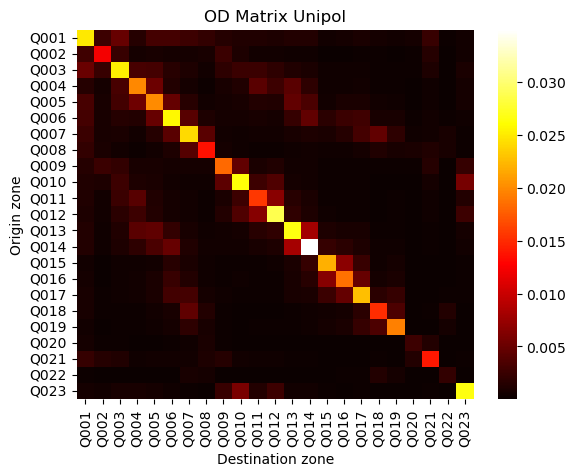

In [38]:
sns.heatmap(ODMatrix, cmap="hot", xticklabels=zones_id, yticklabels=zones_id)
plt.xlabel('Destination zone')
plt.ylabel('Origin zone')
plt.title('OD Matrix Unipol')
plt.show()

IMQ OD MATRIX

In [40]:
# get the file

sp_torino = "./Lab2/spostamentiTorino.csv"
sp_df = pd.read_csv(sp_torino)

In [41]:
# conver ORA col to datetime so could extratct hour or date
sp_df['ORA_PAR'] = pd.to_datetime(sp_df['ORA_PAR'], errors='coerce') #coerce wont crash if there are bad formats

/tmp/ipykernel_430/2280507452.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sp_df['ORA_PAR'] = pd.to_datetime(sp_df['ORA_PAR'], errors='coerce') #coerce wont crash if there are bad formats


In [42]:
# keep the entire ds without time filtering
dsp_f_time_filtered = sp_df.copy()

In [48]:
# init OD

ODMatrix_IMQ = np.zeros((23, 23))

for dest in range(23):

    dest_code = 'Q' + str(dest + 1).zfill(3)
    for orig in range(23):
        orig_code = 'Q' + str(orig + 1).zfill(3)
        n = dsp_f_time_filtered[(dsp_f_time_filtered['COD_ZONA_PAR'] == orig_code) &
                              (dsp_f_time_filtered['COD_ZONA_ARR'] == dest_code) &
                              (dsp_f_time_filtered['SESSO'] == 1)].shape[0]
        ODMatrix_IMQ[orig, dest] = n

# normalize the OD matrix
ODMatrix_IMQ /= np.sum(ODMatrix_IMQ)

try:
    np.savetxt("./Lab2/ODM_IMQ.csv", ODMatrix_IMQ, delimiter=",")
    print('OD matrix successfully saved into CSV file.')
except Exception as e:
    print(f'Something went wrong: {e}')

OD matrix successfully saved into CSV file.


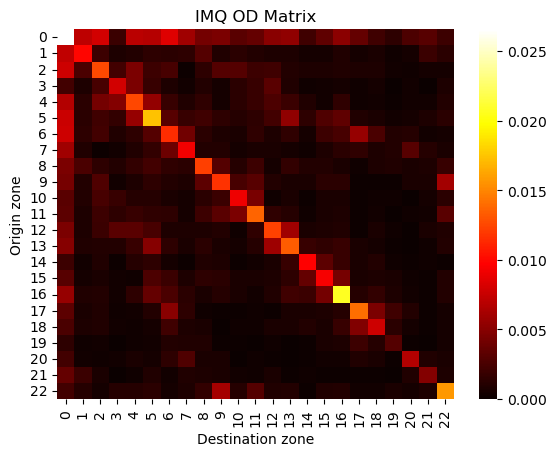

In [45]:
sns.heatmap(ODMatrix_IMQ, cmap="hot")
plt.xlabel('Destination zone')
plt.ylabel('Origin zone')
plt.title('IMQ OD Matrix')
plt.show()

In [49]:
# get our OD metrices

odm_unipol = './Lab2/ODM_Unipol.csv'
odm_imq ='./Lab2/ODM_IMQ.csv'

df_odm_unipol = pd.read_csv(odm_unipol, header=None).values
df_odm_imq = pd.read_csv(odm_imq, header=None).values

In [50]:
# chck if the metrices have the same dimensions
if df_odm_imq.shape !=df_odm_unipol.shape:
    raise ValueError("two metrices have dofferent shapes ")

In [51]:
# compute distances : Manhattan, Euclidean, Maximum

def compute_distances(matrix1, matrix2):

    # normalize both matrices and make sure they sum to 1
    matrix1 = matrix1 / np.sum(matrix1)
    matrix2 = matrix2 / np.sum(matrix2)

    # init the distances
    dist1, dist2, dist3 = 0, 0, 0

    # calculate distances
    for row in range(matrix1.shape[0]):
        for col in range(matrix1.shape[1]):
            diff = abs(matrix1[row, col] - matrix2[row, col])
            dist1 += diff
            dist2 += diff ** 2
            dist3 = max(dist3, diff)
    dist2 = mt.sqrt(dist2)

    return dist1, dist2, dist3


In [52]:
# pass them to the function
manhattan, euclidean, maximum = compute_distances(df_odm_unipol, df_odm_imq)

In [53]:
# create the data frame with the results

data = {
    "Distance Type": ["Manhattan (D-1)", "Euclidean (D-2)", "Maximum (D-inf)"],
    "Value": [manhattan, euclidean, maximum]
}
df = pd.DataFrame(data)
print(df)

     Distance Type     Value
0  Manhattan (D-1)  0.547927
1  Euclidean (D-2)  0.054731
2  Maximum (D-inf)  0.021646


3.a : compare results => see if ppl with similar profile have similar behavior

UNIPOL GENDER MATRIX

In [59]:
def create_normalized_od_matrix(data, zones_id, normalize=True):
    num_zones = len(zones_id)
    od_matrix = np.zeros((num_zones, num_zones))
    for orig in range(num_zones):
        for dest in range(num_zones):
            od_matrix[orig, dest] = data[
                (data['COD_ZONA_PAR'] == zones_id[orig]) &
                (data['COD_ZONA_ARR'] == zones_id[dest])
            ].shape[0]

    if normalize and np.sum(od_matrix) > 0:
        od_matrix = od_matrix / np.sum(od_matrix)

    return od_matrix

In [60]:
# create OD matrix based on Gender

od_matrix_norm_m = create_normalized_od_matrix(df_filtered[df_filtered['genere'] == 'M'], zones_id)
od_matrix_norm_f = create_normalized_od_matrix(df_filtered[df_filtered['genere'] == 'F'], zones_id)

In [61]:
# plot Gender based OD matrices
def plot_od_matrix(od_matrix, zones_id, title):
    sns.heatmap(od_matrix, cmap="hot", xticklabels=zones_id, yticklabels=zones_id)
    plt.xlabel('Destination Zone')
    plt.ylabel('Origin Zone')
    plt.title(title)
    plt.show()

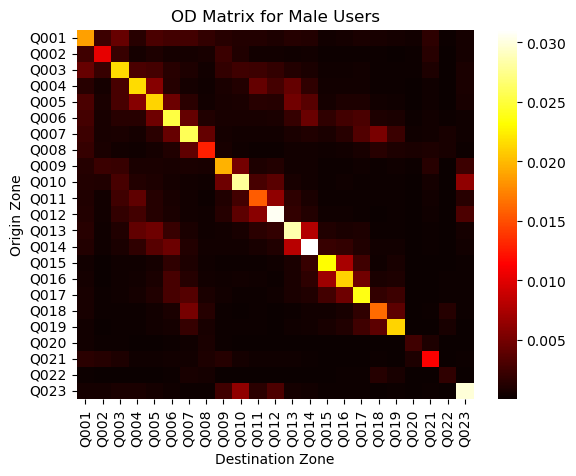

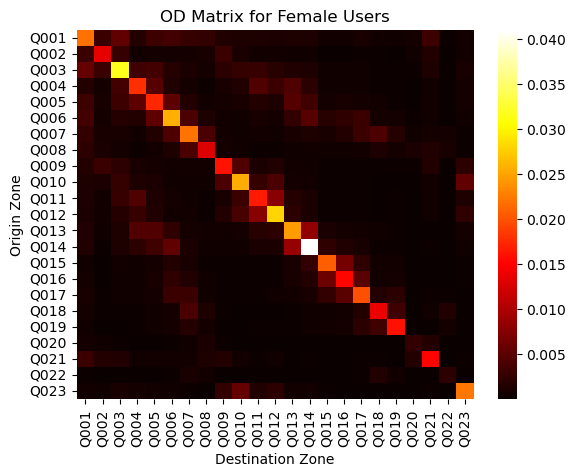

In [62]:
plot_od_matrix(od_matrix_norm_m, zones_id, 'OD Matrix for Male Users')
plot_od_matrix(od_matrix_norm_f, zones_id, 'OD Matrix for Female Users')

In [113]:
# save matrices to CSV

np.savetxt("./Lab2/ODM_Unipol_Female_norm.csv", od_matrix_norm_f, delimiter=",")
np.savetxt("./Lab2/ODM_Unipol_male_norm.csv", od_matrix_norm_m, delimiter=",")
print('OD matrices saved for Male and Female users.')

OD matrices saved for Male and Female users.


IMQ GENDER MATRIX

In [64]:
df = pd.read_csv(sp_torino)

df['ORA_PAR'] = pd.to_datetime(df['ORA_PAR'], errors='coerce')

/tmp/ipykernel_430/3713849265.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ORA_PAR'] = pd.to_datetime(df['ORA_PAR'], errors='coerce')


In [65]:
OD_matrix_IMQ_male = np.zeros((23, 23))
OD_matrix_IMQ_female = np.zeros((23, 23))

# create the matrix
for dest in range(23):
    dest_code = 'Q' + str(dest + 1).zfill(3)  #zone code
    for orig in range(23):
        orig_code = 'Q' + str(orig + 1).zfill(3)

        #male =1
        n_male = df[
            (df['COD_ZONA_PAR'] == orig_code) &
            (df['COD_ZONA_ARR'] == dest_code) &
            (df['SESSO'] == 1)
        ].shape[0]
        OD_matrix_IMQ_male[orig, dest] = n_male

        # Female = 2
        n_female = df[
            (df['COD_ZONA_PAR'] == orig_code) &
            (df['COD_ZONA_ARR'] == dest_code) &
            (df['SESSO'] == 2)
        ].shape[0]
        OD_matrix_IMQ_female[orig, dest] = n_female

In [66]:
def create_od_matrix_imq_by_gender(df, zones_id, gender_code):

    num_zones = len(zones_id)
    od_matrix = np.zeros((num_zones, num_zones))

    for orig in range(num_zones):
        orig_code = zones_id[orig]
        for dest in range(num_zones):
            dest_code = zones_id[dest]

            od_matrix[orig, dest] = df[
                (df['COD_ZONA_PAR'] == orig_code) &
                (df['COD_ZONA_ARR'] == dest_code) &
                (df['SESSO'] == gender_code)
            ].shape[0]

    return od_matrix

In [67]:
def normalize_od_matrix(od_matrix):
    """
    Normalize OD matrix so that sum of all entries = 1
    """
    total = np.sum(od_matrix)
    if total > 0:
        return od_matrix / total
    else:
        return od_matrix

In [68]:
zones_id = [f"Q{i+1:03d}" for i in range(23)]

# Raw OD matrices
OD_matrix_IMQ_male_raw = create_od_matrix_imq_by_gender(df, zones_id, gender_code=1)
OD_matrix_IMQ_female_raw = create_od_matrix_imq_by_gender(df, zones_id, gender_code=2)

# Normalized OD matrices
OD_matrix_IMQ_male = normalize_od_matrix(OD_matrix_IMQ_male_raw)
OD_matrix_IMQ_female = normalize_od_matrix(OD_matrix_IMQ_female_raw)

In [69]:
def plot_od_matrix(od_matrix, title):
    sns.heatmap(od_matrix, cmap="hot")
    plt.xlabel('Destination zone')
    plt.ylabel('Origin zone')
    plt.title(title)
    plt.show()

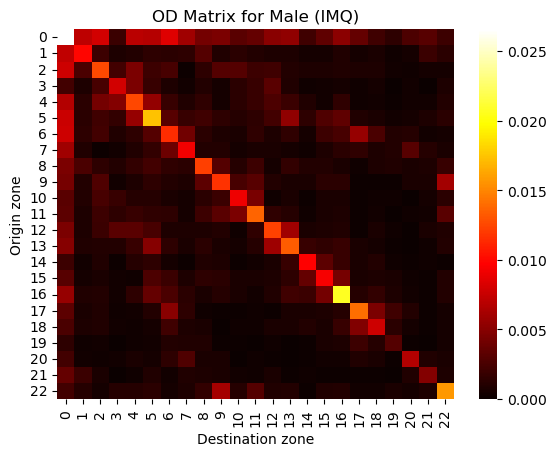

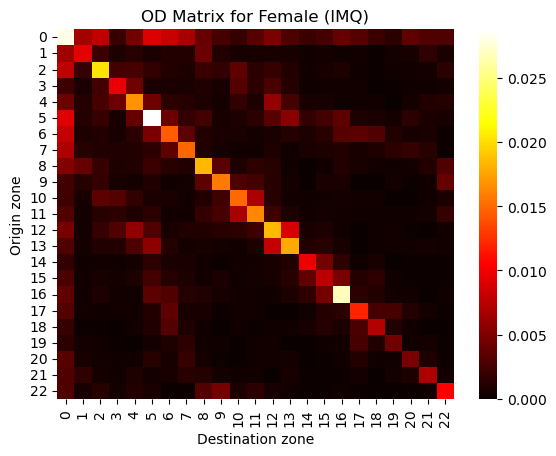

In [70]:
plot_od_matrix(OD_matrix_IMQ_male, 'OD Matrix for Male (IMQ)')
plot_od_matrix(OD_matrix_IMQ_female, 'OD Matrix for Female (IMQ)')

In [71]:
try:
    np.savetxt("Lab2/Norm_ODM_IMQ_Male.csv",OD_matrix_IMQ_male, delimiter=",")
    np.savetxt("Lab2/Norm_ODM_IMQ_Female.csv", OD_matrix_IMQ_female, delimiter=",")
    print('OD matrices successfully saved into CSV files for Male and Female.')
except Exception as e:
    print(f'Something went wrong: {e}')

OD matrices successfully saved into CSV files for Male and Female.


In [72]:
try:
    np.savetxt("Lab2/ODM_IMQ_Male.csv",OD_matrix_IMQ_male_raw, delimiter=",")
    np.savetxt("Lab2/ODM_IMQ_Female.csv", OD_matrix_IMQ_female_raw, delimiter=",")
    print('OD matrices successfully saved into CSV files for Male and Female.')
except Exception as e:
    print(f'Something went wrong: {e}')

OD matrices successfully saved into CSV files for Male and Female.


Unipol Age Group

In [73]:
# add the age and gender columns to the df_info
df_trips = df_trips.merge(df_info[['id_veicolo', 'genere', 'eta_approx']], on='id_veicolo', how='left')

In [74]:
# get the age group

def get_age_classes(age):
    if 11 <= age <= 19:
        return 'GP 1'
    elif 20 <= age <= 49:
        return 'GP 2'
    elif 50 <= age <= 64:
        return 'GP 3'
    elif age >= 65:
        return 'GP 4'
    else:
        return None

In [75]:
df_trips['age_gp'] = df_trips['eta_approx'].apply(get_age_classes)

In [76]:
# filter for age groups
df_filtered = df_trips[
    (df_trips['COD_ZONA_PAR'].notnull()) & (df_trips['COD_ZONA_ARR'].notnull()) & (df_trips['age_gp'].notnull())
]

In [77]:
def calculate_od_matrix_norm(fascia_eta):
    """
    Create and normalize an OD matrix for a given age group.

    Parameters:
    - fascia_eta : age group identifier (as used in df_filtered['age_gp'])

    Returns:
    - ODMatrix_norm : normalized OD matrix (sum = 1)
    """

    # Filter data by age group
    filtered_data = df_filtered[df_filtered['age_gp'] == fascia_eta]

    num_zones = len(zones_id)
    ODMatrix = np.zeros((num_zones, num_zones))

    # Build OD matrix (raw counts)
    for orig in range(num_zones):
        orig_zone = zones_id[orig]
        for dest in range(num_zones):
            dest_zone = zones_id[dest]
            ODMatrix[orig, dest] = filtered_data[
                (filtered_data['COD_ZONA_PAR'] == orig_zone) &
                (filtered_data['COD_ZONA_ARR'] == dest_zone)
            ].shape[0]

    # -------- NORMALIZATION --------
    total_trips = np.sum(ODMatrix)
    if total_trips > 0:
        ODMatrix = ODMatrix / total_trips

    return ODMatrix

OD matrix for GP 1 successfully saved into Lab2/ODM_Unipol_GP_1.csv.


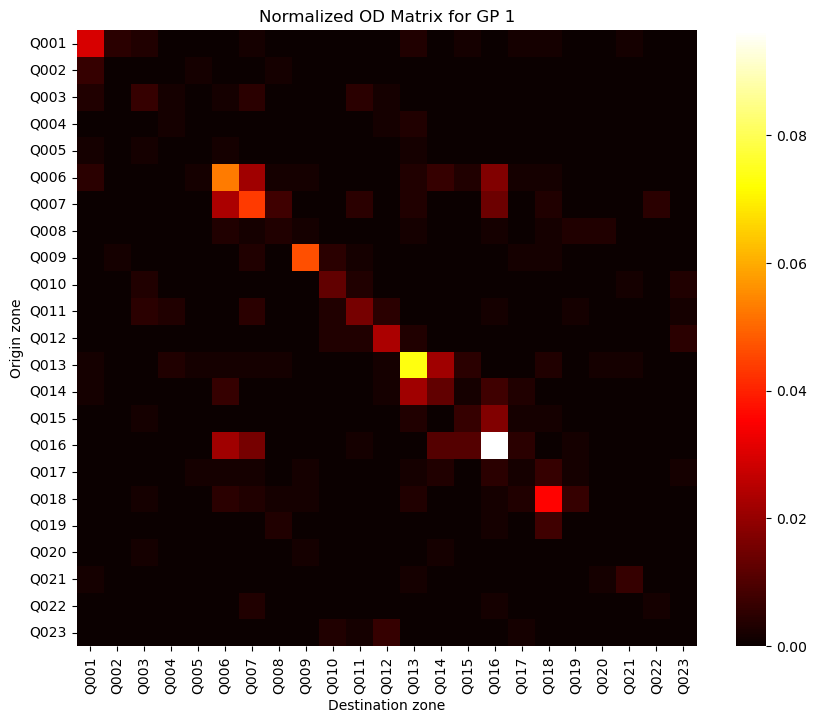

OD matrix for GP 2 successfully saved into Lab2/ODM_Unipol_GP_2.csv.


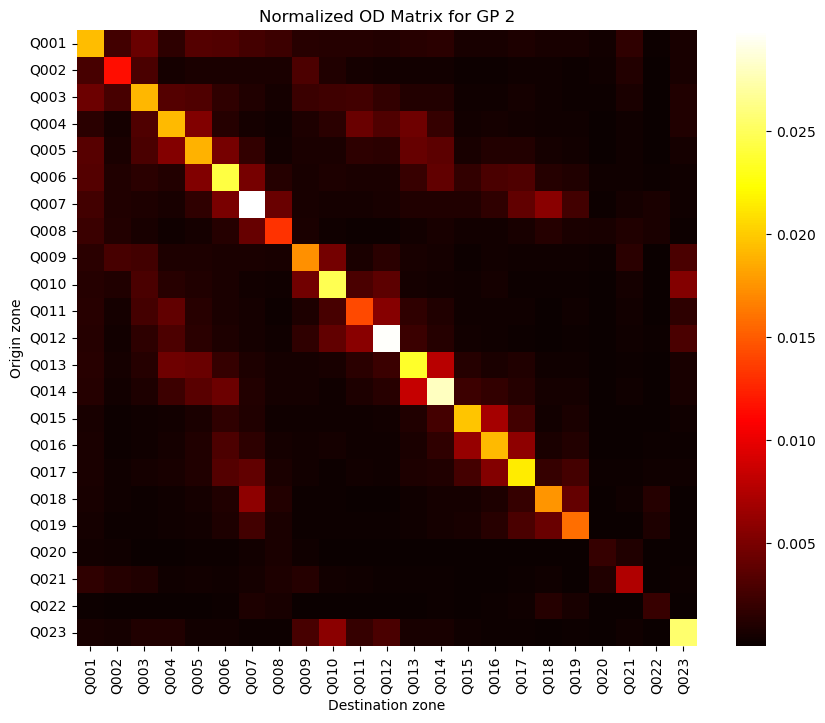

OD matrix for GP 3 successfully saved into Lab2/ODM_Unipol_GP_3.csv.


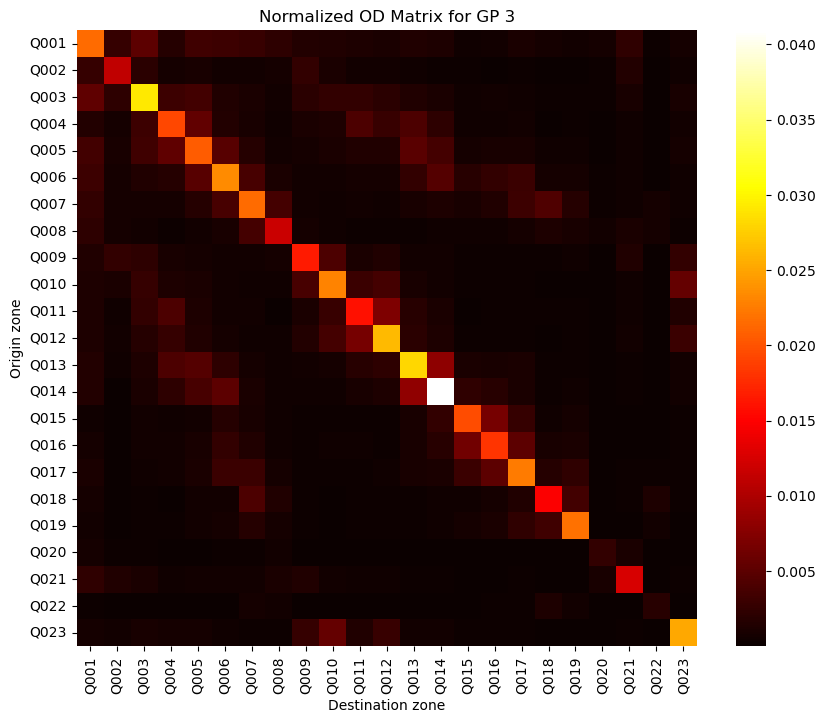

OD matrix for GP 4 successfully saved into Lab2/ODM_Unipol_GP_4.csv.


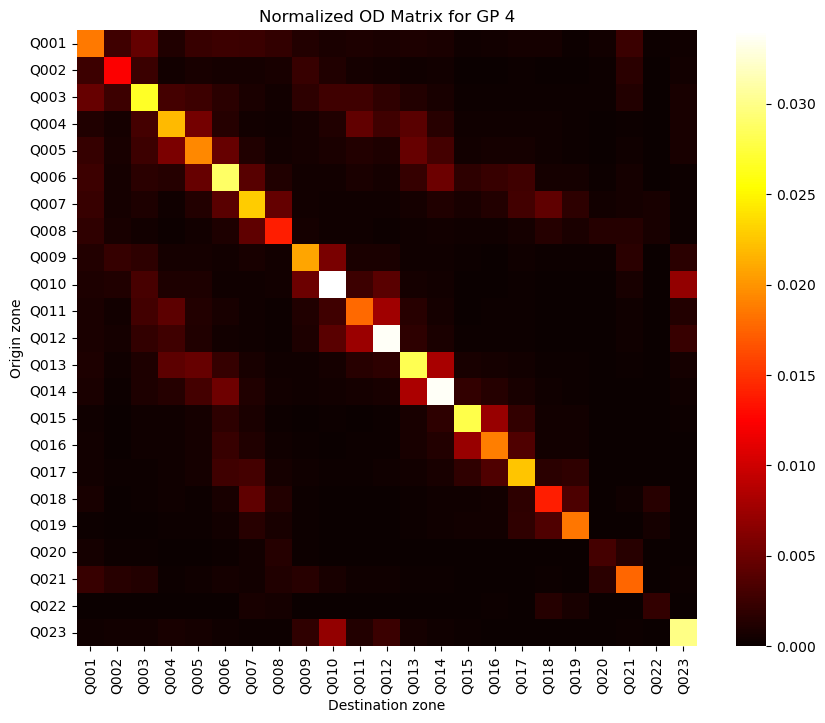

In [78]:
age_classes = ['GP 1', 'GP 2', 'GP 3', 'GP 4']
for classe in age_classes:
    od_matrix = calculate_od_matrix_norm(classe)
    filename = f"Lab2/ODM_Unipol_{classe.replace(' ', '_')}.csv"
    np.savetxt(filename, od_matrix, delimiter=",")
    print(f"OD matrix for {classe} successfully saved into {filename}.")

    plt.figure(figsize=(10, 8))
    sns.heatmap(od_matrix, cmap="hot", xticklabels=zones_id, yticklabels=zones_id)
    plt.xlabel('Destination zone')
    plt.ylabel('Origin zone')
    plt.title(f'Normalized OD Matrix for {classe}')
    plt.show()

In [79]:
print(df_trips.head())

   id_veicolo  id_viaggio        istante_start  lat_start  lon_start  \
0           1           2  2024-08-27 21:15:03     45.069      7.698   
1           1           4  2024-08-27 21:22:47     45.069      7.698   
2           1           5  2024-08-28 08:16:42     45.083      7.675   
3           1           6  2024-08-28 11:47:37     45.068      7.687   
4           1           7  2024-08-29 12:22:22     45.083      7.675   

          istante_stop  lat_stop  lon_stop genere_x COD_ZONA_PAR COD_ZONA_ARR  \
0  2024-08-27 21:16:05    45.069     7.698        M         Q008         Q008   
1  2024-08-27 21:32:03    45.083     7.675        M         Q008         Q006   
2  2024-08-28 08:29:07    45.067     7.688        M         Q006         Q001   
3  2024-08-28 11:54:02    45.083     7.675        M         Q001         Q006   
4  2024-08-29 12:31:44    45.077     7.668        M         Q006         Q006   

         date genere_y  eta_approx age_gp  
0  2024-08-27        M          47  

In [80]:
print(df_info.head())

   id_veicolo commerciale  eta_approx genere
0           1           N          47      M
1           2           N          54      M
2           3           N          34      F
3           4           N          81      M
4           5           N          23      M


In [149]:
# Ensure 'commerciale' is included during the merge

df_trips = df_trips.drop(columns=["genere_x", "genere_y", "eta_approx_x", "eta_approx_y"], errors="ignore")

# 2) Merge once, using suffixes that WON'T create duplicates
df_trips = df_trips.merge(
    df_info[["id_veicolo", "genere", "eta_approx", "commerciale"]],
    on="id_veicolo",
    how="left",
    suffixes=("", "_info")
)

print(df_trips.columns)
print(df_info.columns)

Index(['id_veicolo', 'id_viaggio', 'istante_start', 'lat_start', 'lon_start',
       'istante_stop', 'lat_stop', 'lon_stop', 'COD_ZONA_PAR', 'COD_ZONA_ARR',
       'date', 'age_gp', 'eta_approx_info', 'genere_info', 'eta_approx_info',
       'commerciale_x', 'commerciale_y', 'genere', 'eta_approx',
       'commerciale'],
      dtype='object')
Index(['id_veicolo', 'commerciale', 'eta_approx', 'genere'], dtype='object')


In [150]:
# Check if 'commerciale' is in df_info
print('commerciale' in df_info.columns)

# Check the result of the merge
print(df_trips.head())

True
   id_veicolo  id_viaggio        istante_start  lat_start  lon_start  \
0           1           2  2024-08-27 21:15:03     45.069      7.698   
1           1           4  2024-08-27 21:22:47     45.069      7.698   
2           1           5  2024-08-28 08:16:42     45.083      7.675   
3           1           6  2024-08-28 11:47:37     45.068      7.687   
4           1           7  2024-08-29 12:22:22     45.083      7.675   

          istante_stop  lat_stop  lon_stop COD_ZONA_PAR COD_ZONA_ARR  \
0  2024-08-27 21:16:05    45.069     7.698         Q008         Q008   
1  2024-08-27 21:32:03    45.083     7.675         Q008         Q006   
2  2024-08-28 08:29:07    45.067     7.688         Q006         Q001   
3  2024-08-28 11:54:02    45.083     7.675         Q001         Q006   
4  2024-08-29 12:31:44    45.077     7.668         Q006         Q006   

         date age_gp  eta_approx_info genere_info  eta_approx_info  \
0  2024-08-27   GP 2               47           M          

Trip Goal Metrices comparison

In [145]:
def calculate_od_matrix_commercial(commerciale_filter):

    # Filter for commerciale or non-commerciale trips
    filtered_data = df_trips[df_trips['commerciale'] == commerciale_filter]

    num_zones = len(zones_id)
    ODMatrix = np.zeros((num_zones, num_zones))

    # Build OD matrix (raw counts)
    for orig in range(num_zones):
        orig_zone = zones_id[orig]
        for dest in range(num_zones):
            dest_zone = zones_id[dest]
            ODMatrix[orig, dest] = filtered_data[
                (filtered_data['COD_ZONA_PAR'] == orig_zone) &
                (filtered_data['COD_ZONA_ARR'] == dest_zone)
            ].shape[0]

    # -------- NORMALIZATION --------
    total_trips = np.sum(ODMatrix)
    if total_trips > 0:
        ODMatrix = ODMatrix / total_trips

    return ODMatrix

In [146]:
print(df_trips.columns.tolist())

['id_veicolo', 'id_viaggio', 'istante_start', 'lat_start', 'lon_start', 'istante_stop', 'lat_stop', 'lon_stop', 'COD_ZONA_PAR', 'COD_ZONA_ARR', 'date', 'eta_approx_x', 'age_gp', 'genere_x', 'eta_approx_info', 'genere_info', 'eta_approx_info', 'commerciale_x', 'genere_y', 'eta_approx_y', 'commerciale_y']


In [151]:
df_trips['commerciale']

0         N
1         N
2         N
3         N
4         N
         ..
545377    N
545378    N
545379    N
545380    N
545381    N
Name: commerciale, Length: 545382, dtype: object

In [95]:
od_matrix_commercial = calculate_od_matrix_commercial('S')  # commercial
od_matrix_non_commercial = calculate_od_matrix_commercial('N')  # non commercial

In [96]:
# calculate their differences
diff_matrix = od_matrix_commercial - od_matrix_non_commercial

In [97]:
# compute distances
manhattan, euclidean, maximum = compute_distances(od_matrix_commercial, od_matrix_non_commercial)

In [98]:
np.savetxt("Lab2/ODM_Unipol_Commercial.csv", od_matrix_commercial, delimiter=",")
np.savetxt("Lab2/ODM_Unipol_NonCommercial.csv", od_matrix_non_commercial, delimiter=",")
np.savetxt("Lab2/ODM_Unipol_Difference.csv", diff_matrix, delimiter=",")
print("OD matrices for commercial, non-commercial, and their difference saved successfully.")

OD matrices for commercial, non-commercial, and their difference saved successfully.


In [99]:
distance_data = {
    "Distance Type": ["Manhattan (D-1)", "Euclidean (D-2)", "Maximum (D-inf)"],
    "Value": [manhattan, euclidean, maximum]
}
df_distances = pd.DataFrame(distance_data)

In [100]:
print("\nDistance Metrics between Commercial and Non-Commercial OD Matrices:")
print(df_distances)


Distance Metrics between Commercial and Non-Commercial OD Matrices:
     Distance Type     Value
0  Manhattan (D-1)  0.297142
1  Euclidean (D-2)  0.059316
2  Maximum (D-inf)  0.052925


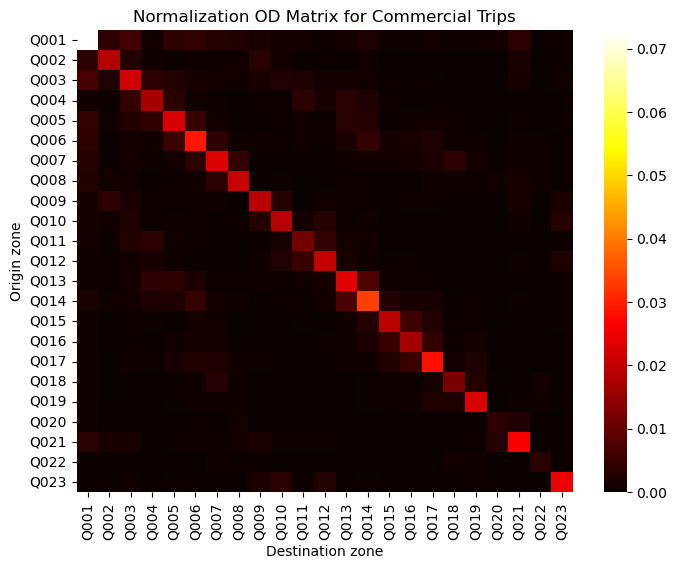

In [101]:
plt.figure(figsize=(8, 6))
sns.heatmap(od_matrix_commercial, cmap="hot", xticklabels=zones_id, yticklabels=zones_id)
plt.xlabel('Destination zone')
plt.ylabel('Origin zone')
plt.title('Normalization OD Matrix for Commercial Trips')
plt.show()

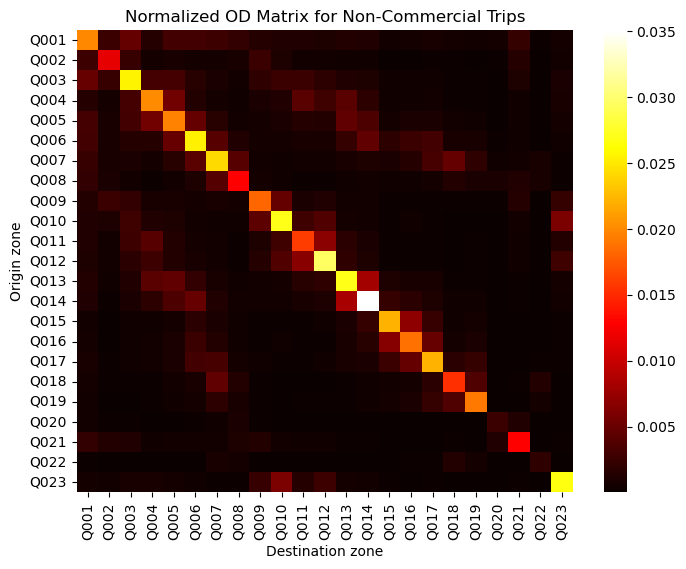

In [102]:
plt.figure(figsize=(8, 6))
sns.heatmap(od_matrix_non_commercial, cmap="hot", xticklabels=zones_id, yticklabels=zones_id)
plt.xlabel('Destination zone')
plt.ylabel('Origin zone')
plt.title('Normalized OD Matrix for Non-Commercial Trips')
plt.show()

IMQ AGE CLASSES MATRIX

In [103]:
sp_df['ORA_PAR'] = pd.to_datetime(sp_df['ORA_PAR'], errors='coerce')

In [104]:
fasce_eta = df['FASCIA_ETA'].dropna().unique()

In [105]:
def calculate_od_matrix_by_age(df, fascia_eta, gender_code, zones_id, plot=True, save=True):
    """
    Create and normalize an OD matrix for a given age group and gender.

    Parameters:
    - df : pandas DataFrame (IMQ data)
    - fascia_eta : age group value (as in df['FASCIA_ETA'])
    - gender_code : 1 = male, 2 = female
    - zones_id : list of zone codes (e.g. ['Q001', ..., 'Q023'])
    - plot : whether to show heatmap
    - save : whether to save CSV

    Returns:
    - ODMatrix_norm : normalized OD matrix (sum = 1)
    """

    # Filter dataframe by age group
    df_filtered = df[df['FASCIA_ETA'] == fascia_eta]

    num_zones = len(zones_id)
    ODMatrix = np.zeros((num_zones, num_zones))

    # Build OD matrix (raw counts)
    for orig in range(num_zones):
        orig_code = zones_id[orig]
        for dest in range(num_zones):
            dest_code = zones_id[dest]
            ODMatrix[orig, dest] = df_filtered[
                (df_filtered['COD_ZONA_PAR'] == orig_code) &
                (df_filtered['COD_ZONA_ARR'] == dest_code) &
                (df_filtered['SESSO'] == gender_code)
            ].shape[0]

    # -------- NORMALIZATION --------
    total_trips = np.sum(ODMatrix)
    if total_trips > 0:
        ODMatrix = ODMatrix / total_trips

    # Plot normalized OD matrix
    if plot:
        plt.figure(figsize=(8, 6))
        sns.heatmap(ODMatrix, cmap="hot")
        plt.xlabel("Destination zone")
        plt.ylabel("Origin zone")
        plt.title(f"Normalized OD Matrix – Age group {fascia_eta}")
        plt.show()

    # Save normalized OD matrix
    if save:
        output_filename = f"Lab2/ODM_IMQ_Fascia_eta_{fascia_eta}.csv"
        np.savetxt(output_filename, ODMatrix, delimiter=",")
        print(f"Normalized OD matrix saved to {output_filename}")

    return ODMatrix

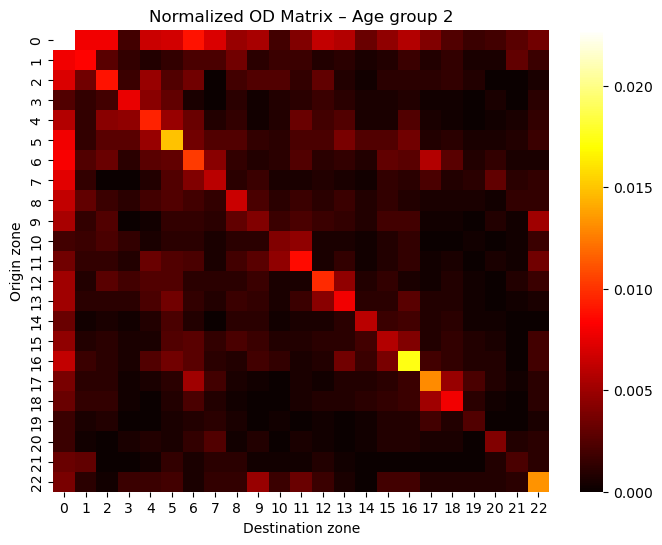

Normalized OD matrix saved to Lab2/ODM_IMQ_Fascia_eta_2.csv


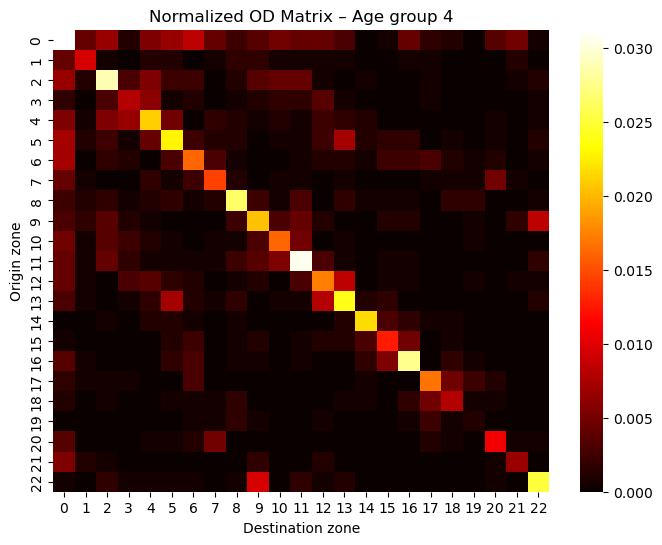

Normalized OD matrix saved to Lab2/ODM_IMQ_Fascia_eta_4.csv


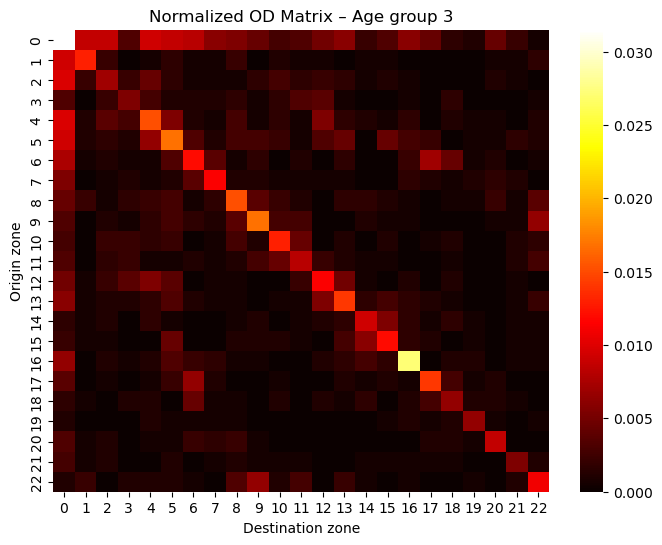

Normalized OD matrix saved to Lab2/ODM_IMQ_Fascia_eta_3.csv


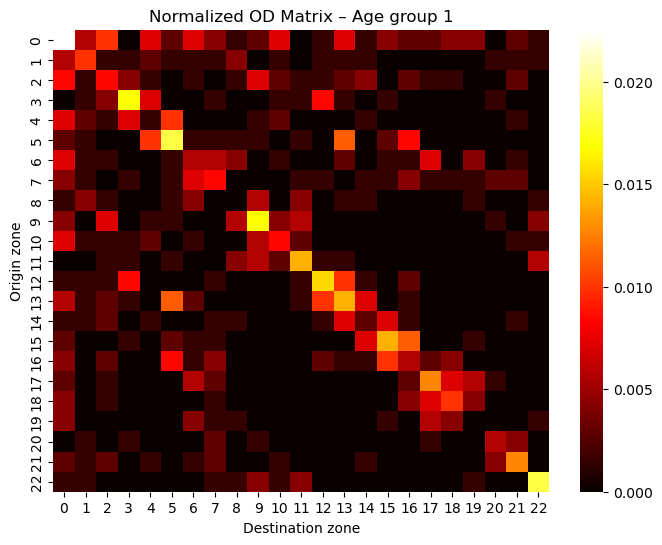

Normalized OD matrix saved to Lab2/ODM_IMQ_Fascia_eta_1.csv


In [106]:
zones_id = [f"Q{i+1:03d}" for i in range(23)]

fasce_eta = df['FASCIA_ETA'].unique()

for fascia in fasce_eta:
    OD_male = calculate_od_matrix_by_age(
        df=df,
        fascia_eta=fascia,
        gender_code=1,
        zones_id=zones_id
    )

IMQ PURPOSE METRICES

IMQ UNIPOL Distance BTW MALE & FEMALE METRICES

In [117]:
files = {
    "IMQ Male": './Lab2/ODM_IMQ_Male.csv',
    "IMQ Female": './Lab2/ODM_IMQ_Female.csv',
    "Unipol Male": './Lab2/ODM_Unipol_male_norm.csv',
    "Unipol Female": './Lab2/ODM_Unipol_Female_norm.csv'
}

In [111]:
# compute distances function
# we pass to metrices we want to compute ditances btw
def compute_distances(matrix1, matrix2):

    matrix1 = matrix1 / np.sum(matrix1)
    matrix2 = matrix2 / np.sum(matrix2)

    dist1, dist2, dist3 = 0, 0, 0

    for row in range(matrix1.shape[0]):
        for col in range(matrix1.shape[1]):
            diff = abs(matrix1[row, col] - matrix2[row, col])
            dist1 += diff
            dist2 += diff ** 2
            dist3 = max(dist3, diff)

    dist2 = mt.sqrt(dist2)

    return dist1, dist2, dist3

In [118]:
odm_matrices = {key: pd.read_csv(value, header=None).values for key, value in files.items()}

In [119]:
# make sure they have same dimensions
matrix_shape = odm_matrices["IMQ Male"].shape
for key, matrix in odm_matrices.items():
    if matrix.shape != matrix_shape:
        raise ValueError(f"matrix {key} has different dimension with respect to others .")

In [120]:
distances_D1 = np.zeros((4, 4))
distances_D2 = np.zeros((4, 4))
distances_Dinf = np.zeros((4, 4))

In [121]:
# compute D1,D2,Dinf distances and store them in symmetric distance metrices
matrix_keys = list(odm_matrices.keys())
for i in range(4):
    for j in range(i, 4):
        dist1, dist2, dist3 = compute_distances(odm_matrices[matrix_keys[i]], odm_matrices[matrix_keys[j]])
        distances_D1[i, j] = dist1  # D-1 (Manhattan Distance)
        distances_D1[j, i] = dist1
        distances_D2[i, j] = dist2  # D-2 (Euclidean Distance)
        distances_D2[j, i] = dist2
        distances_Dinf[i, j] = dist3  # D-inf (Maximum Distance)
        distances_Dinf[j, i] = dist3

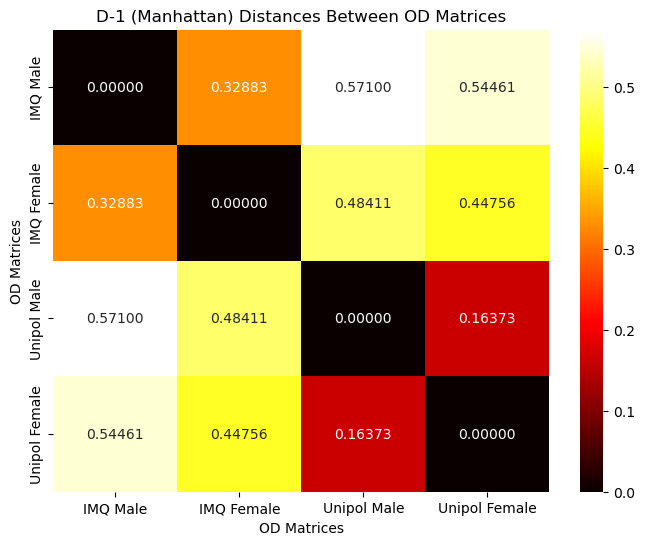

In [122]:

# Heatmap per D-1 (Manhattan Distance)
plt.figure(figsize=(8, 6))
sns.heatmap(distances_D1, xticklabels=matrix_keys, yticklabels=matrix_keys, cmap="hot", annot=True, fmt=".5f")
plt.title("D-1 (Manhattan) Distances Between OD Matrices")
plt.xlabel("OD Matrices")
plt.ylabel("OD Matrices")
plt.show()

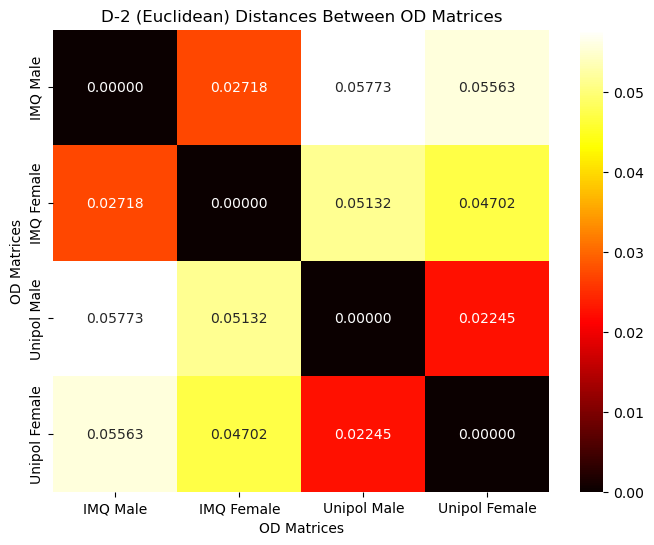

In [123]:
plt.figure(figsize=(8, 6))
sns.heatmap(distances_D2, xticklabels=matrix_keys, yticklabels=matrix_keys, cmap="hot", annot=True, fmt=".5f")
plt.title("D-2 (Euclidean) Distances Between OD Matrices")
plt.xlabel("OD Matrices")
plt.ylabel("OD Matrices")
plt.show()

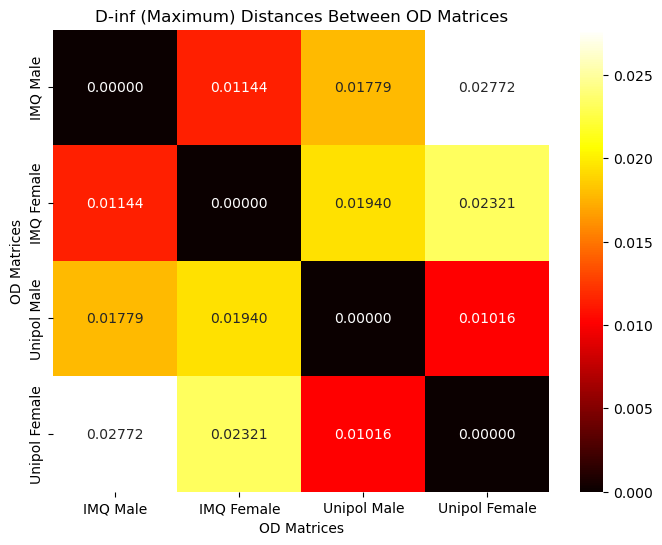

In [124]:
plt.figure(figsize=(8,6))
sns.heatmap(distances_Dinf, xticklabels=matrix_keys, yticklabels=matrix_keys, cmap="hot", annot=True, fmt=".5f")
plt.title("D-inf (Maximum) Distances Between OD Matrices")
plt.xlabel("OD Matrices")
plt.ylabel("OD Matrices")
plt.show()

In [ ]:
# age group files IMQ & UNIPOL

files = {
    "IMQ age 11-19": './Lab2/ODM_IMQ_Fascia_eta_1.csv',
    "IMQ age 20-49": './Lab2/ODM_IMQ_Fascia_eta_2.csv',
    "IMQ age 50-64": './Lab2/ODM_IMQ_Fascia_eta_3.csv',
    "IMQ age 65+": './Lab2/ODM_IMQ_Fascia_eta_4.csv',
    "Unipol age 11-19": './Lab2/ODM_Unipol_GP_1.csv',
    "Unipol age 20-49": './Lab2/ODM_Unipol_GP_2.csv',
    "Unipol age 50-64": './Lab2/ODM_Unipol_GP_3.csv',
    "Unipol age 65+": './Lab2/ODM_Unipol_GP_4.csv'
}

In [126]:
odm_matrices = {key: pd.read_csv(value, header=None).values for key, value in files.items()}

In [127]:
distances_D1 = np.zeros((len(files), len(files)))
distances_D2 = np.zeros((len(files), len(files)))
distances_Dinf = np.zeros((len(files), len(files)))

In [128]:
matrix_keys = list(odm_matrices.keys())

In [129]:
for i in range(len(files)):
    for j in range(i, len(files)):
        dist1, dist2, dist3 = compute_distances(odm_matrices[matrix_keys[i]], odm_matrices[matrix_keys[j]])
        distances_D1[i, j] = dist1  # D-1 (Manhattan Distance)
        distances_D1[j, i] = dist1
        distances_D2[i, j] = dist2  # D-2 (Euclidean Distance)
        distances_D2[j, i] = dist2
        distances_Dinf[i, j] = dist3  # D-inf (Maximum Distance)
        distances_Dinf[j, i] = dist3

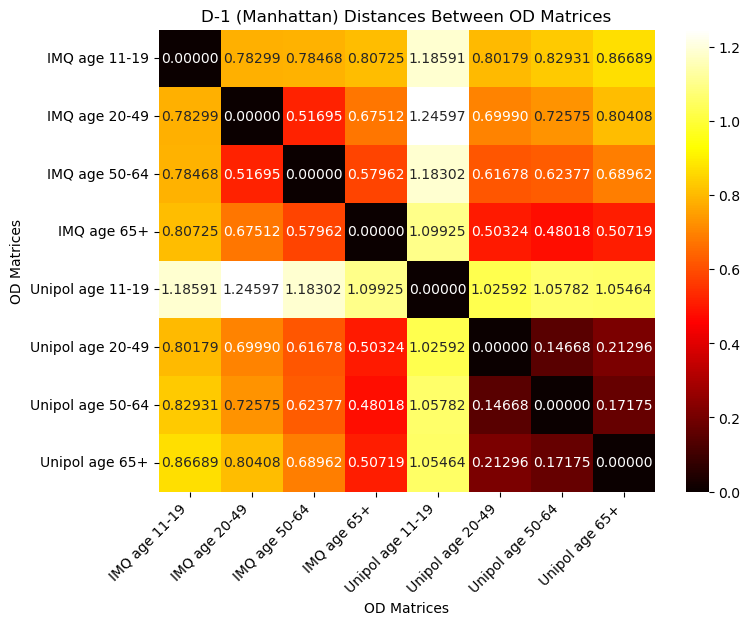

In [130]:
 # Heatmap per D-1 (Manhattan Distance)
plt.figure(figsize=(8,6))
sns.heatmap(distances_D1, xticklabels=matrix_keys, yticklabels=matrix_keys, cmap="hot", annot=True, fmt=".5f")
plt.title("D-1 (Manhattan) Distances Between OD Matrices")
plt.xlabel("OD Matrices")
plt.ylabel("OD Matrices")
plt.xticks(rotation=45, ha='right')
plt.show()

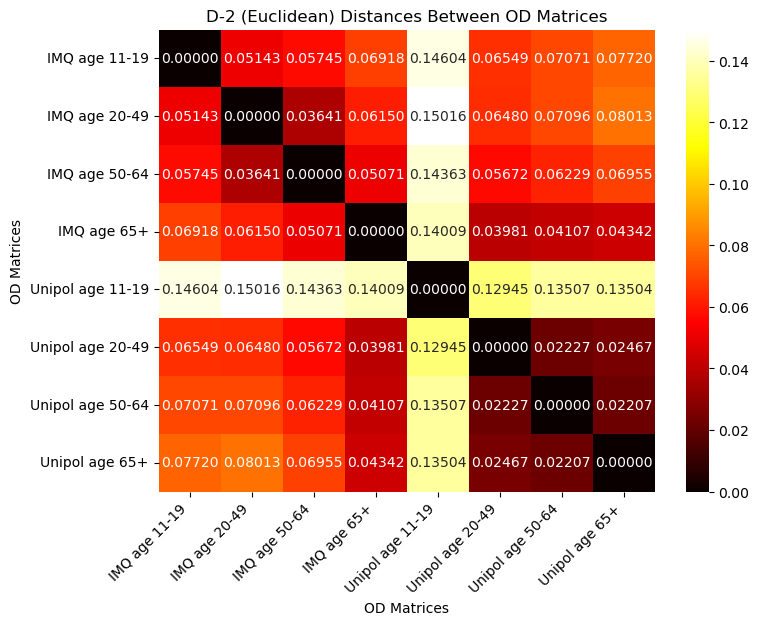

In [131]:
# Heatmap per D-2 (Euclidean Distance)
plt.figure(figsize=(8,6))
sns.heatmap(distances_D2, xticklabels=matrix_keys, yticklabels=matrix_keys, cmap="hot", annot=True, fmt=".5f")
plt.title("D-2 (Euclidean) Distances Between OD Matrices")
plt.xlabel("OD Matrices")
plt.ylabel("OD Matrices")
plt.xticks(rotation=45, ha='right')
plt.show()

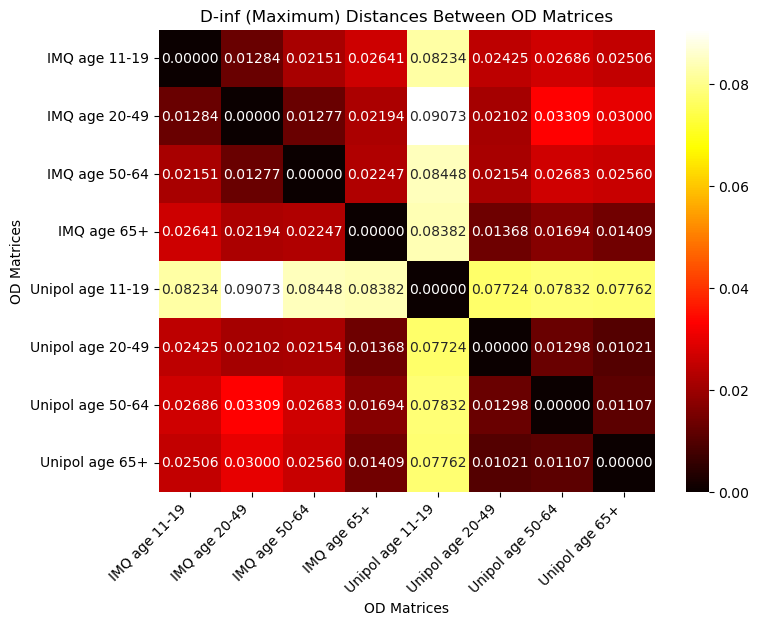

In [132]:
# Heatmap per D-inf (Maximum Distance)
plt.figure(figsize=(8, 6))
sns.heatmap(distances_Dinf, xticklabels=matrix_keys, yticklabels=matrix_keys, cmap="hot", annot=True, fmt=".5f")
plt.title("D-inf (Maximum) Distances Between OD Matrices")
plt.xlabel("OD Matrices")
plt.ylabel("OD Matrices")
plt.xticks(rotation=45, ha='right')
plt.show()

In [133]:
columns = ['Dataset 1', 'Dataset 2', 'D-1 (Manhattan)', 'D-2 (Euclidean)', 'D-inf (Maximum)']
distance_table = []

In [134]:
for i in range(len(files)):
    for j in range(i + 1, len(files)):
        distance_table.append([
            matrix_keys[i],
            matrix_keys[j],
            distances_D1[i, j],
            distances_D2[i, j],
            distances_Dinf[i, j]
        ])

distance_df = pd.DataFrame(distance_table, columns=columns)

print(distance_df)

           Dataset 1         Dataset 2  D-1 (Manhattan)  D-2 (Euclidean)  \
0      IMQ age 11-19     IMQ age 20-49         0.782993         0.051432   
1      IMQ age 11-19     IMQ age 50-64         0.784683         0.057447   
2      IMQ age 11-19       IMQ age 65+         0.807247         0.069179   
3      IMQ age 11-19  Unipol age 11-19         1.185907         0.146035   
4      IMQ age 11-19  Unipol age 20-49         0.801792         0.065494   
5      IMQ age 11-19  Unipol age 50-64         0.829312         0.070709   
6      IMQ age 11-19    Unipol age 65+         0.866891         0.077204   
7      IMQ age 20-49     IMQ age 50-64         0.516950         0.036412   
8      IMQ age 20-49       IMQ age 65+         0.675122         0.061495   
9      IMQ age 20-49  Unipol age 11-19         1.245971         0.150159   
10     IMQ age 20-49  Unipol age 20-49         0.699901         0.064799   
11     IMQ age 20-49  Unipol age 50-64         0.725750         0.070959   
12     IMQ a

Task 3.B : consider IMQ DS, what gender of user has greater difference in behavior across age groups ?

In [136]:
sp_torino = "./Lab2/spostamentiTorino.csv"
df_sp = pd.read_csv(sp_torino)

In [137]:
# we need to filter for age gp and gender
age_groups = ['11-19', '20-49', '50-64', '65+']
gender_filters = ['male', 'female']

In [138]:
# age mapping
age_map = {'11-19': 1, '20-49': 2, '50-64': 3, '65+': 4}

In [139]:
def generate_od_matrix(df, age_group, gender):
    matr = np.zeros((23, 23))
    for dest in range(23):
        dest_code = 'Q' + str(dest + 1).zfill(3)
        for orig in range(23):
            orig_code = 'Q' + str(orig + 1).zfill(3)
            gender_filter = 1 if gender == 'male' else 2
            n = df[(df['COD_ZONA_PAR'] == orig_code) &
                   (df['COD_ZONA_ARR'] == dest_code) &
                   (df['FASCIA_ETA'] == age_map[age_group]) &
                   (df['SESSO'] == gender_filter)].shape[0]
            matr[orig, dest] = n
    return matr

In [140]:
def compute_distances(matr1, matr2):
    N1 = np.sum(matr1)
    N2 = np.sum(matr2)
    matr1 = matr1 / N1 if N1 != 0 else matr1
    matr2 = matr2 / N2 if N2 != 0 else matr2

    dist1, dist2, dist3 = 0, 0, 0
    for row in range(23):
        for col in range(23):
            d = abs(matr1[row, col] - matr2[row, col])
            dist1 += d
            dist2 += d ** 2
            dist3 = max(dist3, d)
    dist2 = mt.sqrt(dist2)
    return dist1, dist2, dist3

In [141]:
# init different matrices for mal,female and diff distances

D1_matr_male = np.zeros((4, 4))
D2_matr_male = np.zeros((4, 4))
D3_matr_male = np.zeros((4, 4))

D1_matr_female = np.zeros((4, 4))
D2_matr_female = np.zeros((4, 4))
D3_matr_female = np.zeros((4, 4))

In [142]:
od_matrices_male = {age: generate_od_matrix(df_sp, age, 'male') for age in age_groups}
od_matrices_female = {age: generate_od_matrix(df_sp, age, 'female') for age in age_groups}

In [ ]:
for i, age1 in enumerate(age_groups):
    for j, age2 in enumerate(age_groups):
        D1_matr_male[i, j], D2_matr_male[i, j], D3_matr_male[i, j] = compute_distances(
            od_matrices_male[age1], od_matrices_male[age2])
        D1_matr_female[i, j], D2_matr_female[i, j], D3_matr_female[i, j] = compute_distances(
            od_matrices_female[age1], od_matrices_female[age2])

In [ ]:
x_ticks = age_groups
y_ticks = age_groups

def plot_heatmap(matrix, title, ylabel):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt=".5f", cmap="hot", xticklabels=x_ticks, yticklabels=y_ticks)
    plt.title(title)
    plt.xlabel('Age Groups')
    plt.ylabel(ylabel)
    plt.show()

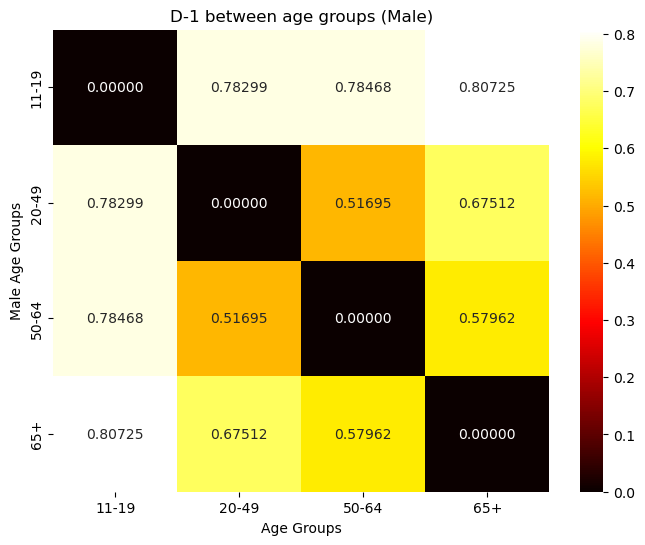

In [ ]:
plot_heatmap(D1_matr_male, 'D-1 between age groups (Male)', 'Male Age Groups')

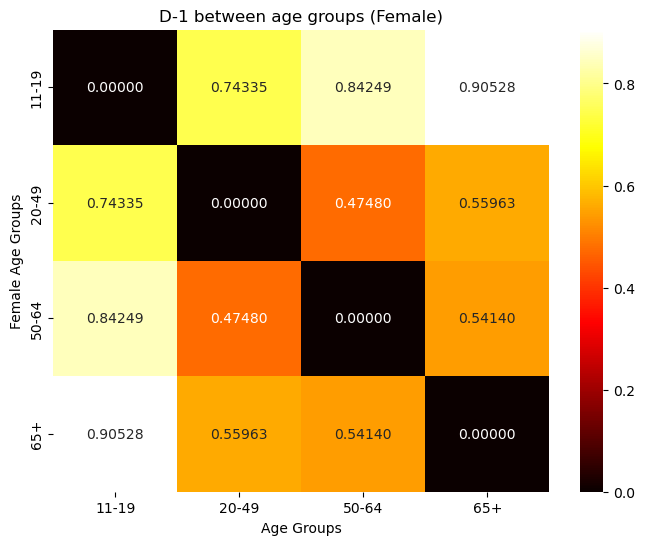

In [ ]:
plot_heatmap(D1_matr_female, 'D-1 between age groups (Female)', 'Female Age Groups')


In [ ]:
def generate_unique_comparisons(D1_matrix, D2_matrix, D3_matrix, gender):
    comparisons = []
    for i, age1 in enumerate(age_groups):
        for j, age2 in enumerate(age_groups):
            if i < j:
                comparisons.append({
                    "Gender": gender,
                    "Age Group 1": age1,
                    "Age Group 2": age2,
                    "D-1": D1_matrix[i, j],
                    "D-2": D2_matrix[i, j],
                    "D-3": D3_matrix[i, j]
                })
    return pd.DataFrame(comparisons)

In [ ]:
unique_table_male = generate_unique_comparisons(D1_matr_male, D2_matr_male, D3_matr_male, "Male")
unique_table_female = generate_unique_comparisons(D1_matr_female, D2_matr_female, D3_matr_female, "Female")

In [ ]:
unique_full_table = pd.concat([unique_table_male, unique_table_female], ignore_index=True)


In [ ]:
print(unique_full_table)


    Gender Age Group 1 Age Group 2       D-1       D-2       D-3
0     Male       11-19       20-49  0.782993  0.051432  0.012837
1     Male       11-19       50-64  0.784683  0.057447  0.021511
2     Male       11-19         65+  0.807247  0.069179  0.026411
3     Male       20-49       50-64  0.516950  0.036412  0.012766
4     Male       20-49         65+  0.675122  0.061495  0.021943
5     Male       50-64         65+  0.579617  0.050709  0.022469
6   Female       11-19       20-49  0.743353  0.059710  0.020027
7   Female       11-19       50-64  0.842493  0.066739  0.025719
8   Female       11-19         65+  0.905279  0.085466  0.033935
9   Female       20-49       50-64  0.474796  0.035164  0.010676
10  Female       20-49         65+  0.559627  0.052934  0.020255
11  Female       50-64         65+  0.541398  0.045011  0.016747


3.C:Consider IMQ dataset, what kind of users are more likely to use Car2GO and Enjoy?

In [ ]:
multipolygons = []
zones_id = []
for i, feature in enumerate(gj["features"]):
    polygons = [Polygon(polygon_coords[0]) for polygon_coords in feature["geometry"]["coordinates"]]
    multipolygons.append(MultiPolygon(polygons))
    zones_id.append(f"Q{i + 1:03d}")

In [ ]:
gdf_zones = gpd.GeoDataFrame({'zone_id': zones_id, 'geometry': multipolygons})
gdf_zones.set_crs(epsg=4326, inplace=True)

zone_id                                           geometry
0     Q001  MULTIPOLYGON (((7.69186 45.07049, 7.6915 45.06...
1     Q002  MULTIPOLYGON (((7.67494 45.04515, 7.67417 45.0...
2     Q003  MULTIPOLYGON (((7.66865 45.06233, 7.67018 45.0...
3     Q004  MULTIPOLYGON (((7.64158 45.05197, 7.64313 45.0...
4     Q005  MULTIPOLYGON (((7.65479 45.07331, 7.65583 45.0...
5     Q006  MULTIPOLYGON (((7.66296 45.09101, 7.66299 45.0...
6     Q007  MULTIPOLYGON (((7.67953 45.07582, 7.6795 45.07...
7     Q008  MULTIPOLYGON (((7.69869 45.06555, 7.69772 45.0...
8     Q009  MULTIPOLYGON (((7.66486 45.01675, 7.66402 45.0...
9     Q010  MULTIPOLYGON (((7.65796 45.01958, 7.65798 45.0...
10    Q011  MULTIPOLYGON (((7.63863 45.05135, 7.64001 45.0...
11    Q012  MULTIPOLYGON (((7.62981 45.05417, 7.62985 45.0...
12    Q013  MULTIPOLYGON (((7.60898 45.06395, 7.60938 45.0...
13    Q014  MULTIPOLYGON (((7.62536 45.07682, 7.62489 45.0...
14    Q015  MULTIPOLYGON (((7.64647 45.0954, 7.649 45.0947...
15    Q016  MULTIPOLYGON (((7.65681 45.13478, 7.65733 45.1...
16    Q017  MULTIPOLYGON (((7.68787 45.11637, 7.68807 45.1...
17    Q018  MULTIPOLYGON (((7.69806 45.09888, 7.69834 45.0...
18    Q019  MULTIPOLYGON (((7.70626 45.11102, 7.7059 45.11...
19    Q020  MULTIPOLYGON (((7.74543 45.04889, 7.74308 45.0...
20    Q021  MULTIPOLYGON (((7.71236 45.05663, 7.71246 45.0...
21    Q022  MULTIPOLYGON (((7.72181 45.10454, 7.7221 45.10...
22    Q023  MULTIPOLYGON (((7.59185 45.04246, 7.59258 45.0...

In [ ]:
df_trips = df_trips.merge(df_info[['id_veicolo', 'genere']], on='id_veicolo', how='left')

gdf_trips_start = gpd.GeoDataFrame(df_trips, geometry=gpd.points_from_xy(df_trips['lon_start'], df_trips['lat_start']))
gdf_trips_stop = gpd.GeoDataFrame(df_trips, geometry=gpd.points_from_xy(df_trips['lon_stop'], df_trips['lat_stop']))

gdf_trips_start.set_crs(epsg=4326, inplace=True)
gdf_trips_stop.set_crs(epsg=4326, inplace=True)

start_zones = gpd.sjoin(gdf_trips_start, gdf_zones, how='left', predicate='intersects')
stop_zones = gpd.sjoin(gdf_trips_stop, gdf_zones, how='left', predicate='intersects')

df_trips['COD_ZONA_PAR'] = start_zones['zone_id']
df_trips['COD_ZONA_ARR'] = stop_zones['zone_id']

df_trips['date'] = pd.to_datetime(df_trips['istante_start']).dt.date
df_filtered = df_trips[
    (df_trips['COD_ZONA_PAR'].notnull()) &
    (df_trips['COD_ZONA_ARR'].notnull())
]


In [ ]:
num_zones = len(gdf_zones)
ODMatrix = np.zeros((num_zones, num_zones))

print(num_zones)

23


In [ ]:
import numpy as np

def create_od_matrix(data, zones_id, normalize=True):
    num_zones = len(zones_id)
    od_matrix = np.zeros((num_zones, num_zones))

    for orig in range(num_zones):
        orig_zone = zones_id[orig]
        for dest in range(num_zones):
            dest_zone = zones_id[dest]
            od_matrix[orig, dest] = data[
                (data['COD_ZONA_PAR'] == orig_zone) &
                (data['COD_ZONA_ARR'] == dest_zone)
            ].shape[0]

    # Normalize matrix if requested
    if normalize:
        total = np.sum(od_matrix)
        if total > 0:
            od_matrix = od_matrix / total

    return od_matrix


In [ ]:
OD_raw = create_od_matrix(df_filtered, zones_id, normalize=False)


In [ ]:
# not normalized

for orig in range(num_zones):
    orig_zone = zones_id[orig]
    for dest in range(num_zones):
        dest_zone = zones_id[dest]
        ODMatrix[orig, dest] = df_filtered[
            (df_filtered['COD_ZONA_PAR'] == orig_zone) &
            (df_filtered['COD_ZONA_ARR'] == dest_zone)
        ].shape[0]

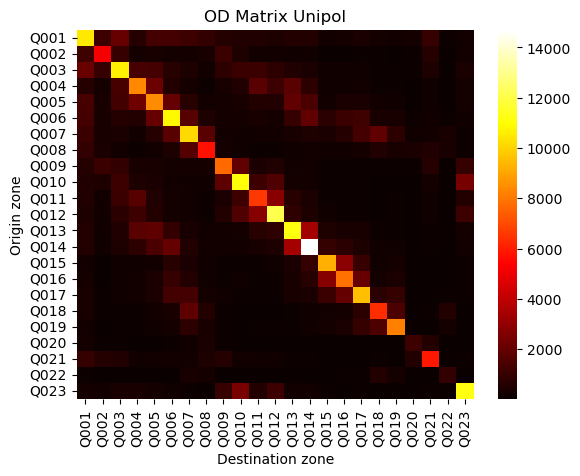

In [ ]:
sns.heatmap(ODMatrix, cmap="hot", xticklabels=zones_id, yticklabels=zones_id)
plt.xlabel('Destination zone')
plt.ylabel('Origin zone')
plt.title('OD Matrix Unipol')
plt.show()

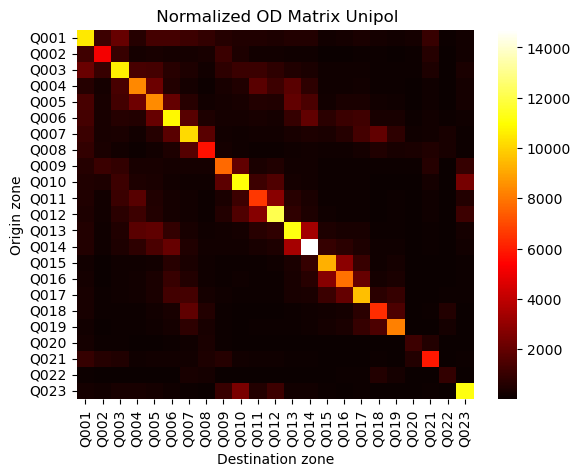

In [ ]:
sns.heatmap(OD_raw, cmap="hot", xticklabels=zones_id, yticklabels=zones_id)
plt.xlabel('Destination zone')
plt.ylabel('Origin zone')
plt.title(' Normalized OD Matrix Unipol')
plt.show()

In [ ]:
def compute_od_matrix(collection, geojson_path, matrix_size, output_csv, title):

    od_matrix = np.zeros((matrix_size, matrix_size))

    # Load zones geometry
    with open(geojson_path) as f:
        gj = geojson.load(f)

    # Build OD matrix with raw counts
    for origin_index in range(matrix_size):
        orig_zone = gj["features"][origin_index]["geometry"]["coordinates"]
        for dest_index in range(matrix_size):
            dest_zone = gj["features"][dest_index]["geometry"]["coordinates"]

            pipeline = [
                {
                    "$project": {
                        "init_loc": 1,
                        "final_loc": 1,
                    }
                },
                {
                    "$match": {
                        "init_loc": {
                            "$geoWithin": {
                                "$geometry": {
                                    "type": "MultiPolygon",
                                    "coordinates": orig_zone
                                }
                            }
                        },
                        "final_loc": {
                            "$geoWithin": {
                                "$geometry": {
                                    "type": "MultiPolygon",
                                    "coordinates": dest_zone
                                }
                            }
                        },
                    }
                },
                {"$count": "total_rentals"},
            ]

            results = list(collection.aggregate(pipeline))
            od_matrix[origin_index, dest_index] = (
                results[0]["total_rentals"] if results else 0
            )

    # ---------- NORMALIZE OD MATRIX ----------
    total_trips = np.sum(od_matrix)
    if total_trips > 0:
        od_matrix = od_matrix / total_trips

    print("OD matrix normalized (sum = 1).")

    # Save normalized OD matrix
    np.savetxt(output_csv, od_matrix, delimiter=",")

    # Plot normalized OD matrix
    sns.heatmap(od_matrix, cmap="hot")
    plt.xlabel("Destination Zone")
    plt.ylabel("Origin Zone")
    plt.title(title + " (Normalized)")
    plt.show()

    return od_matrix


In [ ]:
Bookings_collection_Car2Go = db["ictts_PermanentBookings"]
Bookings_collection_Enjoy = db["ictts_enjoy_PermanentBookings"]

OD matrix normalized (sum = 1).


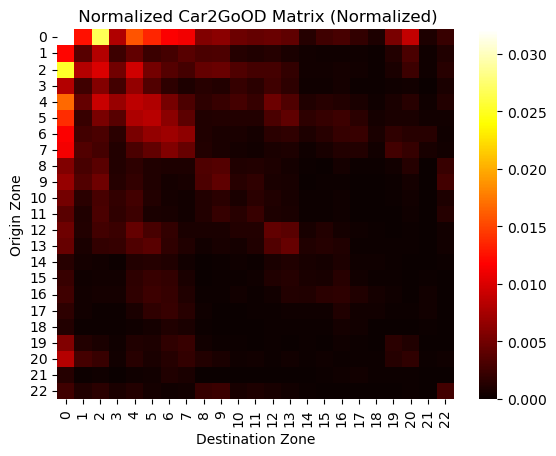

array([[3.21326510e-02, 1.25357214e-02, 2.66166013e-02, 7.95839702e-03,
        1.56924968e-02, 1.34661394e-02, 1.16634545e-02, 1.11151725e-02,
        5.74034691e-03, 6.24709244e-03, 4.68531933e-03, 4.27826145e-03,
        4.63547551e-03, 4.12042268e-03, 1.28763209e-03, 2.56695687e-03,
        2.96570745e-03, 1.93560178e-03, 9.55339935e-04, 5.31667442e-03,
        8.82235662e-03, 8.80574201e-04, 2.20143550e-03],
       [1.20123613e-02, 3.72997940e-03, 8.05808467e-03, 2.39250349e-03,
        4.24503223e-03, 2.36758158e-03, 2.78294677e-03, 3.74659401e-03,
        3.07370240e-03, 3.18169735e-03, 1.35409052e-03, 1.11317871e-03,
        1.27932478e-03, 8.55652289e-04, 4.23672493e-04, 2.82448329e-04,
        3.57214063e-04, 3.23984847e-04, 1.41224164e-04, 1.13810062e-03,
        3.08200970e-03, 2.99062936e-04, 1.02179837e-03],
       [2.52708181e-02, 8.13285040e-03, 9.92722802e-03, 4.97607497e-03,
        9.44540440e-03, 5.04253340e-03, 3.53891141e-03, 2.79125407e-03,
        4.32810527e-03

In [ ]:
    # Compute OD matrix for Car2Go
compute_od_matrix(
        collection=Bookings_collection_Car2Go,
        geojson_path=zones_file,
        matrix_size=23,
        output_csv="Lab2/ODMatrix_Car2Go_3c.csv",
        title=" Normalized Car2GoOD Matrix",
    )

OD matrix normalized (sum = 1).


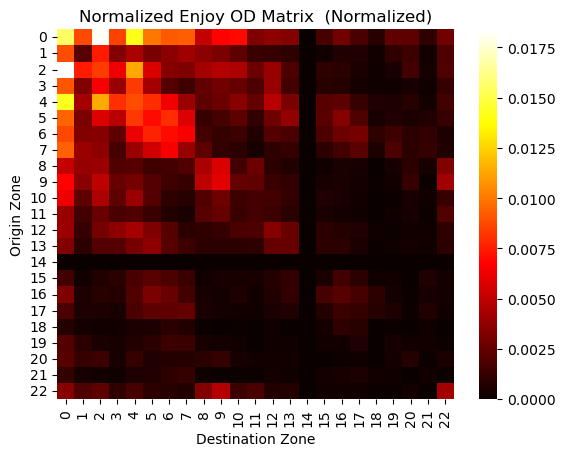

array([[1.55854357e-02, 8.76422378e-03, 1.81175522e-02, 8.54718522e-03,
        1.41488471e-02, 9.95276828e-03, 9.15696022e-03, 9.32232293e-03,
        5.15724960e-03, 6.82121190e-03, 6.90389326e-03, 3.21423773e-03,
        3.59663900e-03, 3.32792459e-03, 1.03351695e-05, 1.68463264e-03,
        2.83183646e-03, 1.72597331e-03, 8.26813564e-04, 2.41842967e-03,
        2.31507798e-03, 1.06452246e-03, 2.81116612e-03],
       [8.77455895e-03, 2.16005044e-03, 7.46199241e-03, 3.31758943e-03,
        4.43378774e-03, 3.05921019e-03, 3.57596866e-03, 4.11339748e-03,
        3.57596866e-03, 3.12122120e-03, 2.32541315e-03, 1.34357204e-03,
        1.28156102e-03, 1.04385212e-03, 0.00000000e+00, 2.68714408e-04,
        6.40780512e-04, 5.78769495e-04, 2.27373730e-04, 1.05418729e-03,
        1.38491272e-03, 2.37708900e-04, 1.86033052e-03],
       [1.83966018e-02, 7.41031657e-03, 8.34048183e-03, 6.26311275e-03,
        1.13170107e-02, 5.71534876e-03, 3.41060595e-03, 3.19356739e-03,
        4.24775468e-03

In [ ]:
# Compute OD matrix for Enjoy
compute_od_matrix(
    collection=Bookings_collection_Enjoy,
    geojson_path=zones_file,
    matrix_size=23,
    output_csv="Lab2/Normalized_ODMatrix_Enjoy_3c.csv",
    title="Normalized Enjoy OD Matrix ",
)

Distance Carsharing IMQ

In [ ]:
imq_data = pd.read_csv('./Lab2/IMQ/IMQData/spostamentiTorino.csv')
car2go_data = pd.read_csv('./Lab2/ODMatrix_Car2Go_3c.csv', header=None)
enjoy_data = pd.read_csv('./Lab2/Normalized_ODMatrix_Enjoy_3c.csv', header=None)

In [ ]:
age_groups = ['11-19', '20-49', '50-64', '65+']
gender_filters = ['male', 'female']

age_map = {'11-19': 1, '20-49': 2, '50-64': 3, '65+': 4}

In [ ]:
def generate_od_matrix_imq(df, age_group, gender):
    matr = np.zeros((23, 23))
    for dest in range(23):
        dest_code = 'Q' + str(dest + 1).zfill(3)
        for orig in range(23):
            orig_code = 'Q' + str(orig + 1).zfill(3)
            gender_filter = 1 if gender == 'male' else 2
            n = df[(df['COD_ZONA_PAR'] == orig_code) &
                   (df['COD_ZONA_ARR'] == dest_code) &
                   (df['FASCIA_ETA'] == age_map[age_group]) &
                   (df['SESSO'] == gender_filter)].shape[0]
            matr[orig, dest] = n
    return matr

In [ ]:
# normalize matrix here before measure distances
def compute_distances(matr1, matr2):
    N1 = np.sum(matr1)
    N2 = np.sum(matr2)
    matr1 = matr1 / N1 if N1 != 0 else matr1
    matr2 = matr2 / N2 if N2 != 0 else matr2

    dist1, dist2, dist3 = 0, 0, 0
    for row in range(23):
        for col in range(23):
            d = abs(matr1[row, col] - matr2[row, col])
            dist1 += d
            dist2 += d ** 2
            dist3 = max(dist3, d)
    dist2 = mt.sqrt(dist2)
    return dist1, dist2, dist3

def load_od_matrix(matrix_data):
    matr = matrix_data.values.reshape((23, 23))
    return matr

In [ ]:
od_matrix_car2go = load_od_matrix(car2go_data)
od_matrix_enjoy = load_od_matrix(enjoy_data)

comparison_table = []

In [ ]:
for gender in gender_filters:
    for age_group in age_groups:
        matr_imq = generate_od_matrix_imq(imq_data, age_group, gender)

        dist1_car2go, dist2_car2go, dist3_car2go = compute_distances(matr_imq, od_matrix_car2go)
        dist1_enjoy, dist2_enjoy, dist3_enjoy = compute_distances(matr_imq, od_matrix_enjoy)

        comparison_table.append({
            "Gender": gender,
            "Age Group": age_group,
            "Platform": "Car2Go",
            "D-1": dist1_car2go,
            "D-2": dist2_car2go,
            "D-3": dist3_car2go
        })

        comparison_table.append({
            "Gender": gender,
            "Age Group": age_group,
            "Platform": "Enjoy",
            "D-1": dist1_enjoy,
            "D-2": dist2_enjoy,
            "D-3": dist3_enjoy
        })

comparison_df = pd.DataFrame(comparison_table)

comparison_df.to_csv("od_comparison_table.csv", index=False)

print(comparison_df)

    Gender Age Group Platform       D-1       D-2       D-3
0     male     11-19   Car2Go  0.990654  0.074856  0.016820
1     male     11-19    Enjoy  0.978186  0.070281  0.014134
2     male     20-49   Car2Go  0.672211  0.054445  0.018760
3     male     20-49    Enjoy  0.674102  0.049372  0.015190
4     male     50-64   Car2Go  0.769589  0.064010  0.025483
5     male     50-64    Enjoy  0.783540  0.063398  0.024995
6     male       65+   Car2Go  0.928433  0.090464  0.028461
7     male       65+    Enjoy  0.959793  0.088951  0.029000
8   female     11-19   Car2Go  0.898572  0.073870  0.032510
9   female     11-19    Enjoy  0.917126  0.071495  0.033881
10  female     20-49   Car2Go  0.737087  0.068414  0.026992
11  female     20-49    Enjoy  0.775098  0.067958  0.026504
12  female     50-64   Car2Go  0.839556  0.075497  0.022040
13  female     50-64    Enjoy  0.847054  0.071923  0.021552
14  female       65+   Car2Go  0.955317  0.098379  0.029537
15  female       65+    Enjoy  0.975471 

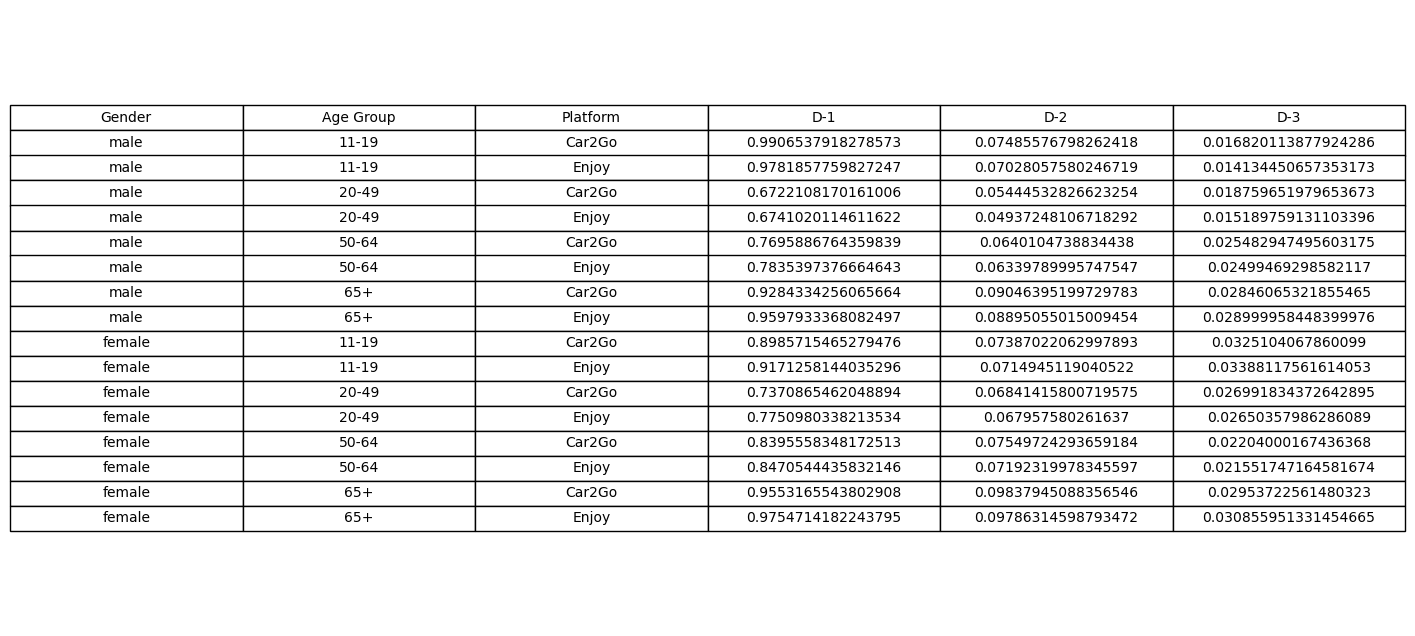

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=comparison_df.values, colLabels=comparison_df.columns, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.5, 1.5)

plt.savefig("Lab2/od_comparison_table.png", bbox_inches='tight', dpi=300)
plt.show()


3D. Compare the OD matrices from the 3 datasets overall.

In [ ]:
# ODM Normalized Matrix

def build_normalized_od_imq(data, zones=23, gender_code=1, save_path=None):

    OD = np.zeros((zones, zones))

    for orig in range(zones):
        orig_code = 'Q' + str(orig + 1).zfill(3)
        for dest in range(zones):
            dest_code = 'Q' + str(dest + 1).zfill(3)

            OD[orig, dest] = data[
                (data['COD_ZONA_PAR'] == orig_code) &
                (data['COD_ZONA_ARR'] == dest_code) &
                (data['SESSO'] == gender_code)
            ].shape[0]

    # -------- Normalize --------
    total = OD.sum()
    if total > 0:
        OD = OD / total

    # -------- Save (optional) --------

        np.savetxt(save_path, OD, delimiter=",")

    return OD


In [ ]:
ODMatrix_IMQ_norm = build_normalized_od_imq(
    data=dsp_f_time_filtered,
    zones=23,
    gender_code=1,
    save_path="Lab2/ODM_IMQ_normalized.csv"
)


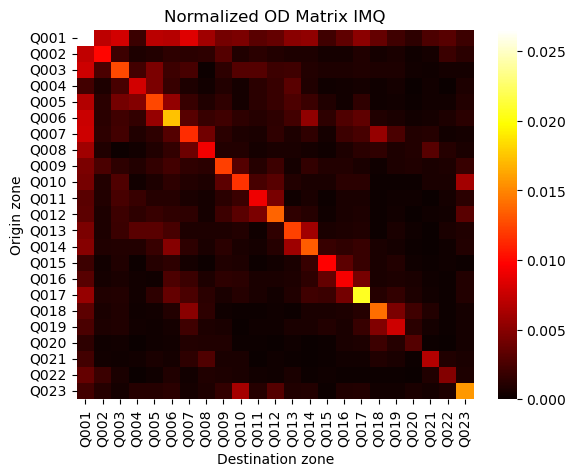

In [ ]:


sns.heatmap(ODMatrix_IMQ_norm, cmap="hot", xticklabels=zones_id, yticklabels=zones_id)
plt.xlabel('Destination zone')
plt.ylabel('Origin zone')
plt.title('Normalized OD Matrix IMQ')
plt.show()


In [ ]:
# Normalized OD matrix for Unipol

def build_normalized_od_unipol(df_filtered, zones_id, save_path=None):

    num_zones = len(zones_id)
    ODMatrix = np.zeros((num_zones, num_zones))

    # Build OD matrix (raw counts)
    for orig in range(num_zones):
        orig_zone = zones_id[orig]
        for dest in range(num_zones):
            dest_zone = zones_id[dest]
            ODMatrix[orig, dest] = df_filtered[
                (df_filtered['COD_ZONA_PAR'] == orig_zone) &
                (df_filtered['COD_ZONA_ARR'] == dest_zone)
            ].shape[0]

    # -------- NORMALIZATION --------
    total_trips = np.sum(ODMatrix)
    if total_trips > 0:
        ODMatrix = ODMatrix / total_trips

    # -------- SAVE (optional) --------
    if save_path is not None:
        np.savetxt(save_path, ODMatrix, delimiter=",")
        print(f"Normalized OD matrix saved to {save_path}")

    return ODMatrix


In [ ]:
ODMatrix_Unipol = build_normalized_od_unipol(
    df_filtered=df_filtered,
    zones_id=zones_id,
    save_path="Lab2/Normalized_ODM_Unipol.csv"
)


Normalized OD matrix saved to Lab2/Normalized_ODM_Unipol.csv


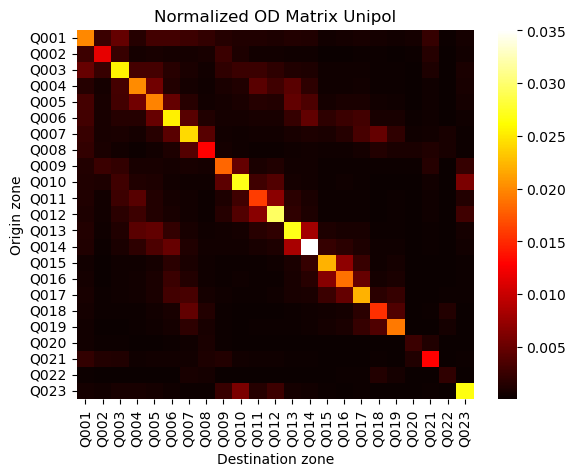

In [ ]:


sns.heatmap(ODMatrix_Unipol, cmap="hot", xticklabels=zones_id, yticklabels=zones_id)
plt.xlabel('Destination zone')
plt.ylabel('Origin zone')
plt.title('Normalized OD Matrix Unipol')
plt.show()


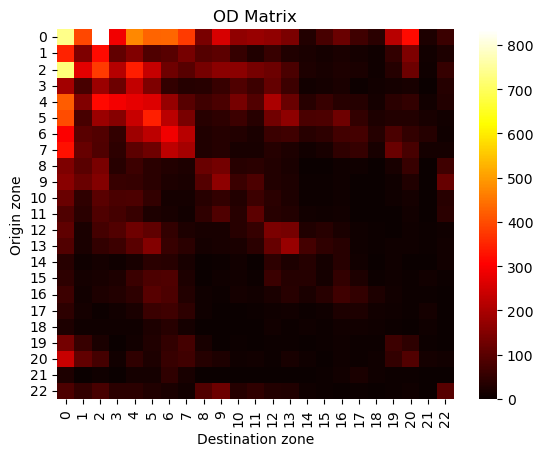

OD matrix successfully saved into CSV file.


In [ ]:

Bookings_collection = db['ictts_PermanentBookings']

# Initialize OD matrix
ODMatrix_Mongo = np.zeros((23, 23))

# For every (origin, destination) pair, compute number of rentals
for dest in range(23):
    for orig in range(23):
        orig_zone = gj['features'][orig]["geometry"]["coordinates"]
        dest_zone = gj['features'][dest]["geometry"]["coordinates"]

        # MongoDB aggregation pipeline
        pipeline = [
            {
                "$project": {
                    "hour": { "$hour": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "init_loc": 1,
                    "final_loc": 1,
                    "init_time": 1
                }
            },
            {
                "$match": {
                    # Only weekdays --> monday to friday {extremes included}
                    "day": { "$gt": 1, "$lt": 7 },
                    # Between 16:00 and 22:00
                    "hour": { "$gte": 16, "$lt": 22 },
                    # Geospatial queries for origin and destination
                    "init_loc": { "$geoWithin": { "$geometry": { "type": "MultiPolygon", "coordinates": orig_zone } } },
                    "final_loc": { "$geoWithin": { "$geometry": { "type": "MultiPolygon", "coordinates": dest_zone } } }
                }
            },
            { "$count": "tot" }
        ]

        # Execute the query and store results
        res = list(Bookings_collection.aggregate(pipeline))
        if len(res) > 0:
            ODMatrix_Mongo[orig, dest] = res[0]["tot"]
        else:
            ODMatrix_Mongo[orig, dest] = 0

# Show OD matrix using Seaborn
sns.heatmap(ODMatrix_Mongo, cmap="hot")
plt.xlabel('Destination zone')
plt.ylabel('Origin zone')
plt.title('OD Matrix')
plt.show()

# Save OD matrix into a CSV file
try:
    np.savetxt("Lab2/ODM_carsharing.csv", ODMatrix_Mongo, delimiter=",")
    print('OD matrix successfully saved into CSV file.')
except Exception as e:
    print('Something went wrong, try again.')
    print(e)

In [ ]:

file_imq = './Lab2/ODM_IMQ.csv'
file_unipol = './Lab2/ODM_Unipol.csv'
file_odcs = './Lab2/ODM_carsharing.csv'

In [ ]:
odm_imq = pd.read_csv(file_imq, header=None).values
odm_unipol = pd.read_csv(file_unipol, header=None).values
odm_odcs = pd.read_csv(file_odcs, header=None).values


In [ ]:
def compute_distances(matrix1, matrix2):
    """
    Compute D-1, D-2, and D-inf distances between two matrices.
    Args:
        matrix1: First matrix (numpy array).
        matrix2: Second matrix (numpy array).
    Returns:
        Tuple of (D-1, D-2, D-inf).
    """
    matrix1 = matrix1 / np.sum(matrix1)
    matrix2 = matrix2 / np.sum(matrix2)

    dist1, dist2, dist3 = 0, 0, 0

    for row in range(matrix1.shape[0]):
        for col in range(matrix1.shape[1]):
            diff = abs(matrix1[row, col] - matrix2[row, col])
            dist1 += diff
            dist2 += diff ** 2
            dist3 = max(dist3, diff)

    dist2 = mt.sqrt(dist2)

    return dist1, dist2, dist3


In [ ]:
if not (odm_imq.shape == odm_unipol.shape == odm_odcs.shape):
    raise ValueError("All matrices must have the same dimensions.")

manhattan_imq_unipol, euclidean_imq_unipol, maximum_imq_unipol = compute_distances(odm_imq, odm_unipol)

manhattan_imq_odcs, euclidean_imq_od1, maximum_imq_od1 = compute_distances(odm_imq, odm_odcs)

manhattan_unipol_od1, euclidean_unipol_od1, maximum_unipol_od1 = compute_distances(odm_unipol, odm_odcs)

In [ ]:
data = {
    "Comparison": [
        "IMQ vs Unipol",
        "IMQ vs CarSharing",
        "Unipol vs CarSharing"
    ],
    "Manhattan (D-1)": [
        manhattan_imq_unipol,
        manhattan_imq_odcs,
        manhattan_unipol_od1
    ],
    "Euclidean (D-2)": [
        euclidean_imq_unipol,
        euclidean_imq_od1,
        euclidean_unipol_od1
    ],
    "Maximum (D-inf)": [
        maximum_imq_unipol,
        maximum_imq_od1,
        maximum_unipol_od1
    ]
}


df = pd.DataFrame(data)

print(df)

             Comparison  Manhattan (D-1)  Euclidean (D-2)  Maximum (D-inf)
0         IMQ vs Unipol         0.547927         0.054731         0.021646
1     IMQ vs CarSharing         0.677963         0.056833         0.018758
2  Unipol vs CarSharing         0.910731         0.096207         0.029667


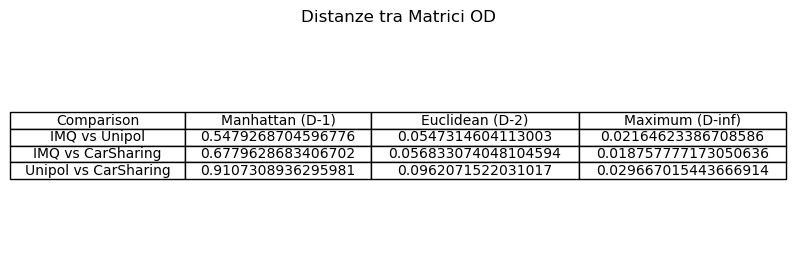

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df.columns))))

plt.title("Distanze tra Matrici OD", fontsize=12)
plt.show()

4. (Optional) Consider carsharing and UnipolTech data, are there better solutions to divide the city area
in terms of mobility analytics rather than using these zones?

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# Make a safe copy of the zones GeoDataFrame
gdf_zones = gdf_zones.copy()

# Ensure we have the list of zone IDs, e.g. ["Q001", ..., "Q023"]
zones_id = gdf_zones["zone_id"].tolist()
n_zones = len(zones_id)
print(f"Number of zones: {n_zones}")
print(f"zones_id: {zones_id}")

Number of zones: 23
zones_id: ['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023']


In [ ]:
gdf_zones["centroid"] = gdf_zones.geometry.centroid
gdf_zones["lon"] = gdf_zones["centroid"].x
gdf_zones["lat"] = gdf_zones["centroid"].y

/tmp/ipykernel_295/1787764664.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_zones["centroid"] = gdf_zones.geometry.centroid


In [ ]:
# gp by origin/dest zones
unipol_out = (
    df_trips
    .groupby("COD_ZONA_PAR")
    .size() #counts trips originating in each zone
    .reindex(zones_id, fill_value=0) #mak sure all zones are represented and 0 for zones with no data
    .values.astype(float)
)

unipol_in = (
    df_trips
    .groupby("COD_ZONA_ARR")
    .size()
    .reindex(zones_id, fill_value=0)
    .values.astype(float)
)

In [ ]:
cs_out = (
    total_bookings
    .groupby("zone_init")
    .size()
    .reindex(range(n_zones), fill_value=0)
    .values.astype(float)
)

cs_in = (
    total_bookings
    .groupby("zone_final")
    .size()
    .reindex(range(n_zones), fill_value=0)
    .values.astype(float)
)


In [ ]:
# creates a single table where each row represents a zone and each column a feature
zone_features = pd.DataFrame({
    "zone_id": zones_id,
    "lon": gdf_zones["lon"].values,
    "lat": gdf_zones["lat"].values,
    "cs_out": cs_out, #no of carhsaring starting in each zone
    "cs_in": cs_in,
    "unipol_out": unipol_out,
    "unipol_in": unipol_in,
})

In [ ]:
from sklearn.preprocessing import StandardScaler


In [ ]:
X = zone_features[["lon", "lat", "cs_out", "cs_in", "unipol_out", "unipol_in"]].values #matrix of features of zones

scaler = StandardScaler() #transforms the data such that each feature has mean 0 and variance 1
X_scaled = scaler.fit_transform(X) # X-mean/std

In [ ]:
K_RANGE = range(2, 22)  # here 2..22
inertias = []       # for Elbow method
silhouettes = []    # for Silhouette scores

for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, n_init=30, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

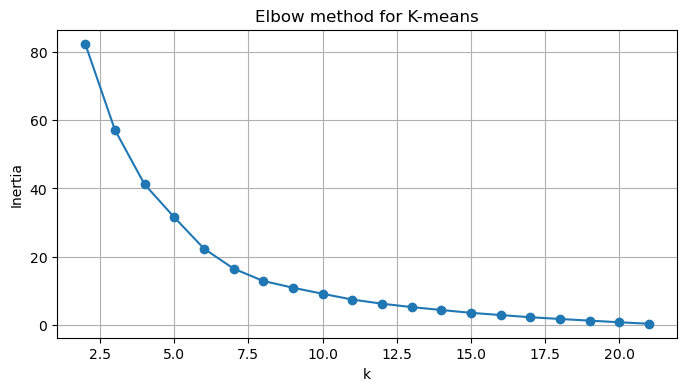

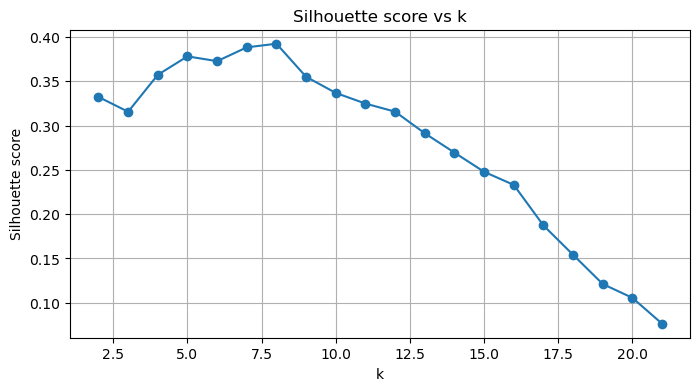

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(list(K_RANGE), inertias, marker="o")
plt.title("Elbow method for K-means")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(list(K_RANGE), silhouettes, marker="o")
plt.title("Silhouette score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

In [ ]:
best_k = 8
kmeans_final = KMeans(n_clusters=best_k, n_init=30, random_state=42)
zone_features["cluster"] = kmeans_final.fit_predict(X_scaled)


In [ ]:
import geopandas as gpd
import matplotlib.colors as mcolors

In [ ]:
# Merge zone_features (with 'zone_id' and 'cluster') back into gdf_zones
gdf_clusters = gdf_zones.merge(
    zone_features[["zone_id", "cluster"]],
    on="zone_id",
    how="left"
)


/tmp/ipykernel_295/3406236833.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", best_k)


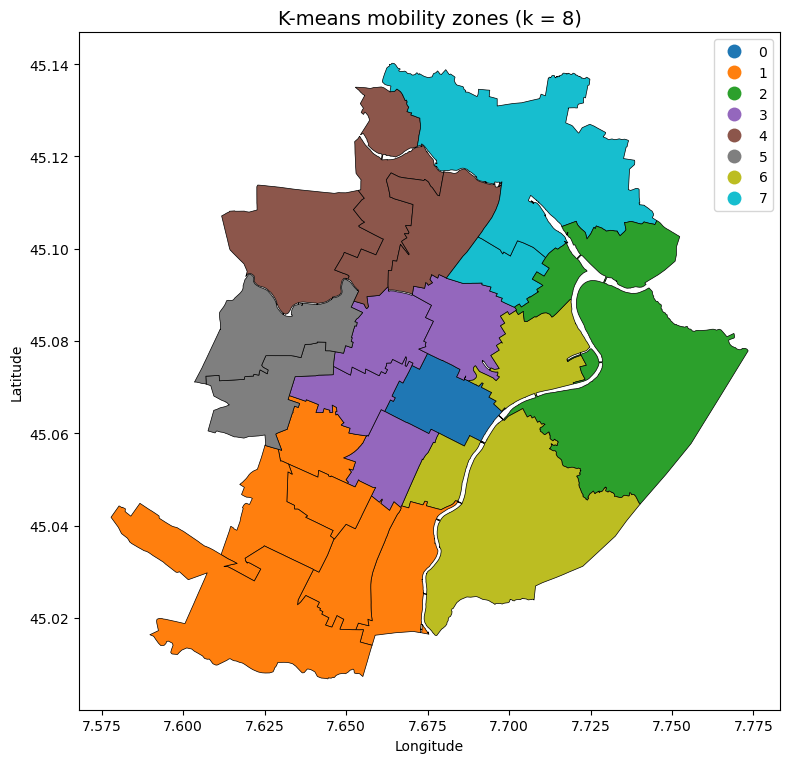

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

# Choose a categorical colormap
cmap = plt.cm.get_cmap("tab10", best_k)

gdf_clusters.plot(
    column="cluster",
    categorical=True,
    cmap=cmap,
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    ax=ax
)

ax.set_title(f"K-means mobility zones (k = {best_k})", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

In [ ]:
# Aggregate features by cluster to understand each zone type
cluster_summary = (
    zone_features
    .groupby("cluster")[["cs_out", "cs_in", "unipol_out", "unipol_in"]]
    .mean()
    .round(1)
)

print(cluster_summary)

          cs_out    cs_in  unipol_out  unipol_in
cluster                                         
0        35991.0  36115.0     25836.0    25776.0
1         7771.2   7753.7     21872.5    21789.2
2         2479.5   2519.5      3098.0     3117.0
3        17594.8  17617.8     25164.8    25118.0
4         3458.0   3435.7     20096.3    20079.3
5         7678.5   7636.0     29267.5    29318.5
6         9462.3   9479.3     12870.7    12848.0
7         2529.5   2484.5     14356.0    14455.5


Q5: For UnipolTech and for CarSharing estimate continuous density for trip generation and
trip distribution, then find a way to compare them.

In [19]:
!pip3 install folium
!pip3 install geojsoncontour
!pip3 install geojson
!pip3 install geopandas

  Using cached folium-0.20.0-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached branca-0.8.2-py3-none-any.whl.metadata (1.7 kB)
Using cached folium-0.20.0-py2.py3-none-any.whl (113 kB)
Using cached branca-0.8.2-py3-none-any.whl (26 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [folium]
  Using cached geojsoncontour-0.5.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached geojson-3.2.0-py3-none-any.whl.metadata (16 kB)
  Using cached xarray-2025.12.0-py3-none-any.whl.metadata (12 kB)
Using cached geojsoncontour-0.5.1-py3-none-any.whl (8.6 kB)
Using cached geojson-3.2.0-py3-none-any.whl (15 kB)
Using cached xarray-2025.12.0-py3-none-any.whl (1.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [geojsoncontour]m [xarray]
  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached pyogrio-0.12.1-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
Using cached geopandas-1.1.1-py3-none-any.whl (338 kB)
Using cached pyogrio-0.12.1-cp313-cp313-manylinux_2_28

In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPolygon, Polygon
from sklearn.neighbors import KernelDensity
import geojson
import geojsoncontour
import folium
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


In [7]:
trip_file =  "/content/Trips_OD_TO.csv"
info_file = "/content/Info_TO.csv"
zones_file = "/content/TorinoZonescol.geojson"

# make each file a DF
df_trips = pd.read_csv(trip_file, sep=",")
df_info  = pd.read_csv(info_file, sep=",")
with open(zones_file) as f:
    gj = geojson.load(f)



In [8]:
# Subsample Trips: take half of the dataset
MAX_TRIPS = len(df_trips) // 2   # integer division

df_trips = df_trips.sample(n=MAX_TRIPS, random_state=42).reset_index(drop=True)

print(f"Using {len(df_trips)} trips for KDE")
print(len(df_trips))


Using 272691 trips for KDE
272691


In [9]:
# Build zones

multipolygons = []
zones_id = []

for i, feature in enumerate(gj["features"]):
    polygons = [Polygon(polygon_coords[0]) for polygon_coords in feature["geometry"]["coordinates"]]
    multipolygons.append(MultiPolygon(polygons))
    zones_id.append(f"Q{i + 1:03d}")

gdf_zones = gpd.GeoDataFrame({'zone_id': zones_id, 'geometry': multipolygons})
gdf_zones.set_crs(epsg=4326, inplace=True)


zone_id                                           geometry
0     Q001  MULTIPOLYGON (((7.69186 45.07049, 7.6915 45.06...
1     Q002  MULTIPOLYGON (((7.67494 45.04515, 7.67417 45.0...
2     Q003  MULTIPOLYGON (((7.66865 45.06233, 7.67018 45.0...
3     Q004  MULTIPOLYGON (((7.64158 45.05197, 7.64313 45.0...
4     Q005  MULTIPOLYGON (((7.65479 45.07331, 7.65583 45.0...
5     Q006  MULTIPOLYGON (((7.66296 45.09101, 7.66299 45.0...
6     Q007  MULTIPOLYGON (((7.67953 45.07582, 7.6795 45.07...
7     Q008  MULTIPOLYGON (((7.69869 45.06555, 7.69772 45.0...
8     Q009  MULTIPOLYGON (((7.66486 45.01675, 7.66402 45.0...
9     Q010  MULTIPOLYGON (((7.65796 45.01958, 7.65798 45.0...
10    Q011  MULTIPOLYGON (((7.63863 45.05135, 7.64001 45.0...
11    Q012  MULTIPOLYGON (((7.62981 45.05417, 7.62985 45.0...
12    Q013  MULTIPOLYGON (((7.60898 45.06395, 7.60938 45.0...
13    Q014  MULTIPOLYGON (((7.62536 45.07682, 7.62489 45.0...
14    Q015  MULTIPOLYGON (((7.64647 45.0954, 7.649 45.0947...
15    Q016  MULTIPOLYGON (((7.65681 45.13478, 7.65733 45.1...
16    Q017  MULTIPOLYGON (((7.68787 45.11637, 7.68807 45.1...
17    Q018  MULTIPOLYGON (((7.69806 45.09888, 7.69834 45.0...
18    Q019  MULTIPOLYGON (((7.70626 45.11102, 7.7059 45.11...
19    Q020  MULTIPOLYGON (((7.74543 45.04889, 7.74308 45.0...
20    Q021  MULTIPOLYGON (((7.71236 45.05663, 7.71246 45.0...
21    Q022  MULTIPOLYGON (((7.72181 45.10454, 7.7221 45.10...
22    Q023  MULTIPOLYGON (((7.59185 45.04246, 7.59258 45.0...

In [10]:
# merge info by spatial join
df_trips = df_trips.merge(df_info[['id_veicolo', 'genere']], on='id_veicolo', how='left')

gdf_trips_start = gpd.GeoDataFrame(
    df_trips, geometry=gpd.points_from_xy(df_trips['lon_start'], df_trips['lat_start']),
    crs="EPSG:4326"
)

gdf_trips_stop = gpd.GeoDataFrame(
    df_trips, geometry=gpd.points_from_xy(df_trips['lon_stop'], df_trips['lat_stop']),
    crs="EPSG:4326"
)

start_zones = gpd.sjoin(gdf_trips_start, gdf_zones, how='left', predicate='intersects')
stop_zones = gpd.sjoin(gdf_trips_stop, gdf_zones, how='left', predicate='intersects')

df_trips['COD_ZONA_PAR'] = start_zones['zone_id']
df_trips['COD_ZONA_ARR'] = stop_zones['zone_id']


In [11]:
# subsample only for KDE Bandwidth search
X_origin_full = df_trips[['lon_start', 'lat_start']].dropna()
X_destination_full = df_trips[['lon_stop', 'lat_stop']].dropna()


# X_origin = X_origin_full.sample(frac=0.5, random_state=42)
# X_destination = X_destination_full.sample(frac=0.5, random_state=42)

X_origin = X_origin_full.sample(frac=0.25, random_state=42)
X_destination = X_destination_full.sample(frac=0.25, random_state=42)




In [12]:
# Fit KDE
bandwidth = 0.02
kde_origin = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X_origin)
kde_destination = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X_destination)


In [13]:
min_lon = min(df_trips["lon_start"].min(), df_trips["lon_stop"].min())
max_lon = max(df_trips["lon_start"].max(), df_trips["lon_stop"].max())
min_lat = min(df_trips["lat_start"].min(), df_trips["lat_stop"].min())
max_lat = max(df_trips["lat_start"].max(), df_trips["lat_stop"].max())

grid_size = 0.003
xgrid = np.arange(min_lon, max_lon, grid_size)
ygrid = np.arange(min_lat, max_lat, grid_size)
X, Y = np.meshgrid(xgrid, ygrid)
xy = np.vstack([X.ravel(), Y.ravel()]).T


In [14]:
# Density Estimation
Z_origin = np.exp(kde_origin.score_samples(xy)).reshape(X.shape)
Z_destination = np.exp(kde_destination.score_samples(xy)).reshape(X.shape)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


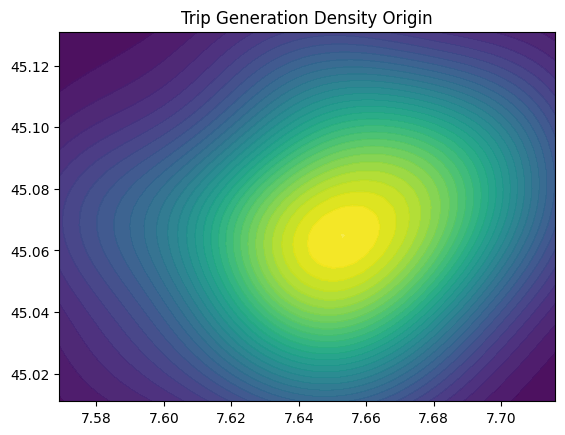

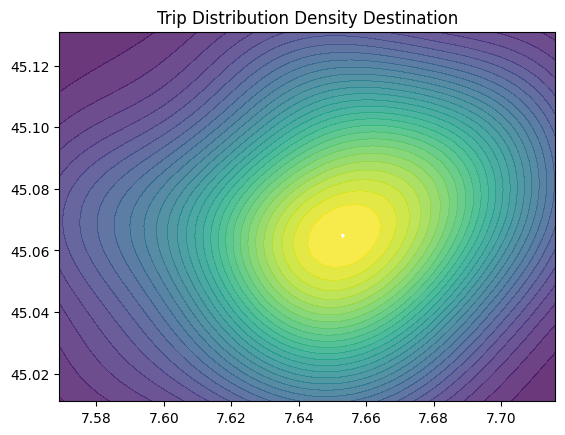

In [15]:
levels = np.linspace(Z_origin.min(), Z_origin.max(), 30)
contourf = plt.contourf(X, Y, Z_destination, levels=levels, alpha=0.8, cmap='viridis')

plt.contourf(X, Y, Z_origin, levels=levels, alpha=0.8, cmap='viridis')
plt.title("Trip Generation Density Origin")
plt.show()

plt.contourf(X, Y, Z_destination, levels=levels, alpha=0.8, cmap='viridis')
plt.title("Trip Distribution Density Destination")
plt.show()


In [16]:
geojson_destination = geojsoncontour.contourf_to_geojson(contourf=contourf)

m_destination = folium.Map(location=[(min_lat + max_lat) / 2, (min_lon + max_lon) / 2], zoom_start=12)
folium.GeoJson(
    geojson_destination,
    style_function=lambda x: {
        'opacity': 0.5,
        'color': x['properties']['stroke'],
    },
).add_to(m_destination)
m_destination

In [17]:
tot_score_origin_1 = 1 / len(X_origin) * kde_origin.score(X_origin)
tot_score_destination = 1 / len(X_destination) * kde_destination.score(X_destination)

In [20]:
FIT_N = 10000      # points used to FIT KDE
EVAL_N = 5000

In [22]:
Xo_fit  = X_origin.sample(n=min(FIT_N, len(X_origin)), random_state=42)
Xd_fit  = X_destination.sample(n=min(FIT_N, len(X_destination)), random_state=42)

Xo_eval = X_origin.sample(n=min(EVAL_N, len(X_origin)), random_state=1)
Xd_eval = X_destination.sample(n=min(EVAL_N, len(X_destination)), random_state=1)

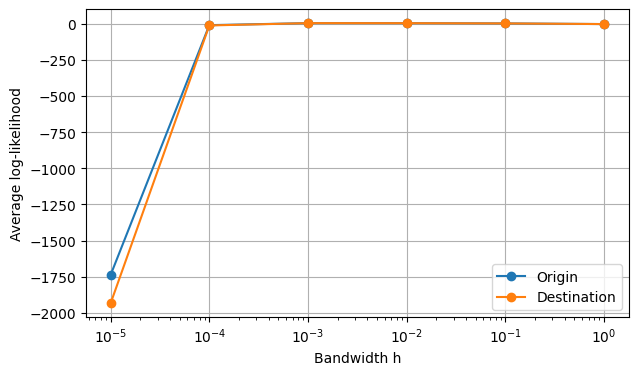

In [23]:
# Bandwidths
h_list = np.logspace(-5, 0, num=6)

logLikelihoodOrigin_list = []
logLikelihoodDestination_list = []

for h in h_list:
    # ---- Origin KDE ----
    kde_o = KernelDensity(kernel='gaussian', bandwidth=h)
    kde_o.fit(Xo_fit)

    llh_o = np.mean(kde_o.score_samples(Xo_eval))
    logLikelihoodOrigin_list.append(llh_o)

    # ---- Destination KDE ----
    kde_d = KernelDensity(kernel='gaussian', bandwidth=h)
    kde_d.fit(Xd_fit)

    llh_d = np.mean(kde_d.score_samples(Xd_eval))
    logLikelihoodDestination_list.append(llh_d)

# Plot
plt.figure(figsize=(7,4))
plt.plot(h_list, logLikelihoodOrigin_list, marker='o', label='Origin')
plt.plot(h_list, logLikelihoodDestination_list, marker='o', label='Destination')
plt.xscale("log")
plt.xlabel("Bandwidth h")
plt.ylabel("Average log-likelihood")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
FIT_N = 10000      # KDE fitting points
EVAL_N = 5000      # evaluation points

# Subsample ONCE
Xo_sub = X_origin.sample(n=min(FIT_N + EVAL_N, len(X_origin)), random_state=42)
Xd_sub = X_destination.sample(n=min(FIT_N + EVAL_N, len(X_destination)), random_state=42)


In [26]:
# Train / validation split on reduced data
X_train_origin, X_val_origin = train_test_split(
    Xo_sub, test_size=EVAL_N, random_state=1
)

X_train_destination, X_val_destination = train_test_split(
    Xd_sub, test_size=EVAL_N, random_state=1
)

In [27]:
# Containers
logLikelihoodOrigin_train_list = []
logLikelihoodOrigin_validation_list = []
logLikelihoodDestination_train_list = []
logLikelihoodDestination_validation_list = []

model_origin_list = []
model_destination_list = []


In [28]:
for h in h_list:
    # ---- ORIGIN ----
    kde_o = KernelDensity(kernel='gaussian', bandwidth=h)
    kde_o.fit(X_train_origin)

    llh_o_train = np.mean(kde_o.score_samples(X_train_origin))
    llh_o_val   = np.mean(kde_o.score_samples(X_val_origin))

    logLikelihoodOrigin_train_list.append(llh_o_train)
    logLikelihoodOrigin_validation_list.append(llh_o_val)
    model_origin_list.append(kde_o)

    # ---- DESTINATION ----
    kde_d = KernelDensity(kernel='gaussian', bandwidth=h)
    kde_d.fit(X_train_destination)

    llh_d_train = np.mean(kde_d.score_samples(X_train_destination))
    llh_d_val   = np.mean(kde_d.score_samples(X_val_destination))

    logLikelihoodDestination_train_list.append(llh_d_train)
    logLikelihoodDestination_validation_list.append(llh_d_val)
    model_destination_list.append(kde_d)

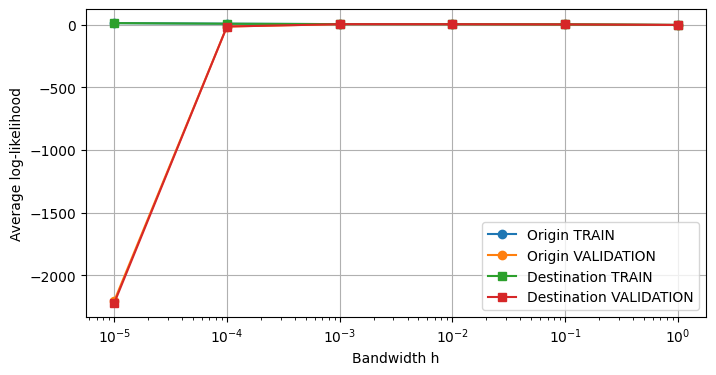

In [29]:
plt.figure(figsize=(8,4))
plt.plot(h_list, logLikelihoodOrigin_train_list, marker='o', label='Origin TRAIN')
plt.plot(h_list, logLikelihoodOrigin_validation_list, marker='o', label='Origin VALIDATION')
plt.plot(h_list, logLikelihoodDestination_train_list, marker='s', label='Destination TRAIN')
plt.plot(h_list, logLikelihoodDestination_validation_list, marker='s', label='Destination VALIDATION')

plt.xscale("log")
plt.xlabel("Bandwidth h")
plt.ylabel("Average log-likelihood")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
db = client['carsharing']
collections = {
    'car2go': 'ictts_PermanentBookings',
    'enjoy': 'ictts_enjoy_PermanentBookings'
}

# Date range for data extraction
d0 = datetime(2017, 9, 1, tzinfo=timezone.utc)
t0 = d0.timestamp()
d1 = datetime(2017, 9, 8, tzinfo=timezone.utc)
t1 = d1.timestamp()

# MongoDB pipeline to extract booking data
pipeline = [
    {'$match': {
        'init_time': {'$gte': t0},
        'final_time': {'$lte': t1}
    }},
    {'$project': {
        '_id': 0,
        'init_loc': 1,
        'final_loc': 1
    }}
]

# Fetch and preprocess data
orig_loc = []
dest_loc = []
for coll_name, coll in collections.items():
    res = list(db[coll].aggregate(pipeline))
    orig_loc += [coords['init_loc']['coordinates'] for coords in res]
    dest_loc += [coords['final_loc']['coordinates'] for coords in res]

X_orig = np.array(orig_loc)
X_dest = np.array(dest_loc)

# Get coordinate bounds
pipeline = [
    {'$group': {
        '_id': None,
        'min_lon_init': {'$min': {'$arrayElemAt': ['$init_loc.coordinates', 0]}},
        'min_lon_final': {'$min': {'$arrayElemAt': ['$final_loc.coordinates', 0]}},
        'max_lon_init': {'$max': {'$arrayElemAt': ['$init_loc.coordinates', 0]}},
        'max_lon_final': {'$max': {'$arrayElemAt': ['$final_loc.coordinates', 0]}},
        'min_lat_init': {'$min': {'$arrayElemAt': ['$init_loc.coordinates', 1]}},
        'min_lat_final': {'$min': {'$arrayElemAt': ['$final_loc.coordinates', 1]}},
        'max_lat_init': {'$max': {'$arrayElemAt': ['$init_loc.coordinates', 1]}},
        'max_lat_final': {'$max': {'$arrayElemAt': ['$final_loc.coordinates', 1]}}
    }}
]

res = {coll_name: list(db[coll].aggregate(pipeline))[0] for coll_name, coll in collections.items()}

In [7]:
min_lon = min([res[c]['min_lon_init'] for c in collections] + [res[c]['min_lon_final'] for c in collections])
max_lon = max([res[c]['max_lon_init'] for c in collections] + [res[c]['max_lon_final'] for c in collections])
min_lat = min([res[c]['min_lat_init'] for c in collections] + [res[c]['min_lat_final'] for c in collections])
max_lat = max([res[c]['max_lat_init'] for c in collections] + [res[c]['max_lat_final'] for c in collections])

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
precision = 0.001
lats = np.arange(min_lat, max_lat + precision, precision)
lons = np.arange(min_lon, max_lon + precision, precision)
X, Y = np.meshgrid(lons, lats)
xy_grid = np.vstack([X.ravel(), Y.ravel()]).T

# Train-test split
X_train_orig, X_valid_orig = train_test_split(X_orig, test_size=0.33, shuffle=True)
X_train_dest, X_valid_dest = train_test_split(X_dest, test_size=0.33, shuffle=True)

# Evaluate log-likelihood
def evaluate_llh(X, Z):
    return 1 / len(X) * Z.sum()

h_list = np.logspace(-4, -3, num=6)
logLikelihoodOrigin_train_list = []
logLikelihoodOrigin_valid_list = []
logLikelihoodDestination_train_list = []
logLikelihoodDestination_valid_list = []

In [12]:
from sklearn.neighbors import KernelDensity


In [13]:
model_origin_list = []
model_destination_list = []

for h in h_list:
    kde_train_orig = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_train_orig)
    Z_train_orig = kde_train_orig.score_samples(X_train_orig)
    logLikelihoodOrigin_train_list.append(evaluate_llh(X_train_orig, Z_train_orig))
    Z_valid_orig = kde_train_orig.score_samples(X_valid_orig)
    logLikelihoodOrigin_valid_list.append(evaluate_llh(X_valid_orig, Z_valid_orig))
    model_origin_list.append(kde_train_orig)

    kde_train_dest = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_train_dest)
    Z_train_dest = kde_train_dest.score_samples(X_train_dest)
    logLikelihoodDestination_train_list.append(evaluate_llh(X_train_dest, Z_train_dest))
    Z_valid_dest = kde_train_dest.score_samples(X_valid_dest)
    logLikelihoodDestination_valid_list.append(evaluate_llh(X_valid_dest, Z_valid_dest))
    model_destination_list.append(kde_train_dest)


In [14]:
# Select the best bandwidth
best_h_index = 3
kde_orig = model_origin_list[best_h_index]
kde_dest = model_destination_list[best_h_index]

Z_orig = np.exp(kde_orig.score_samples(xy_grid)).reshape(X.shape)
Z_dest = np.exp(kde_dest.score_samples(xy_grid)).reshape(X.shape)


In [15]:
import json

In [ ]:
# Load zones GeoJSON
zones_file = r"./Lab2/TorinoZonescol.geojson"
with open(zones_file, 'r') as f:
    zones = json.load(f)


In [22]:
import geojsoncontour
import folium

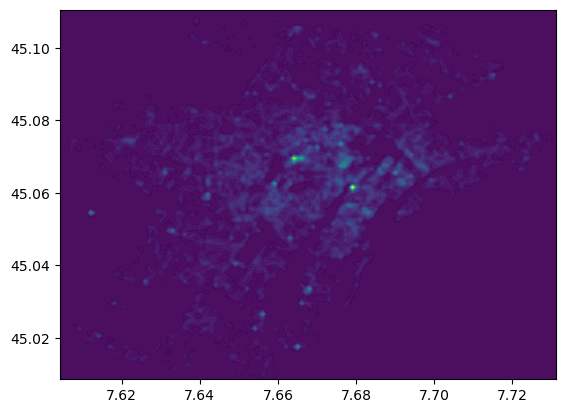

In [23]:
# Plot origins density
levels = np.linspace(Z_orig.min(), Z_orig.max(), 40)
contourf_orig = plt.contourf(X, Y, Z_orig, levels=levels, alpha=0.8)
geojson_orig = geojsoncontour.contourf_to_geojson(contourf=contourf_orig)

m_orig = folium.Map(location=[(min_lat + max_lat) / 2, (min_lon + max_lon) / 2], zoom_start=12)
folium.GeoJson(geojson_orig, style_function=lambda x: {'opacity': 0.3, 'color': x['properties']['stroke']}).add_to(m_orig)
folium.GeoJson(zones, style_function=lambda feature: {'fillColor': 'blue', 'color': 'black', 'weight': 1}).add_to(m_orig)

# Show the map for origins
m_orig.save("origins_density.html")

# Plot destinations density
levels_dest = np.linspace(Z_dest.min(), Z_dest.max(), 40)
contourf_dest = plt.contourf(X, Y, Z_dest, levels=levels_dest, alpha=0.8)
geojson_dest = geojsoncontour.contourf_to_geojson(contourf=contourf_dest)

m_dest = folium.Map(location=[(min_lat + max_lat) / 2, (min_lon + max_lon) / 2], zoom_start=12)
folium.GeoJson(geojson_dest, style_function=lambda x: {'opacity': 0.3, 'color': x['properties']['stroke']}).add_to(m_dest)
folium.GeoJson(zones, style_function=lambda feature: {'fillColor': 'blue', 'color': 'black', 'weight': 1}).add_to(m_dest)

# Show the map for destinations
m_dest.save("destinations_density.html")

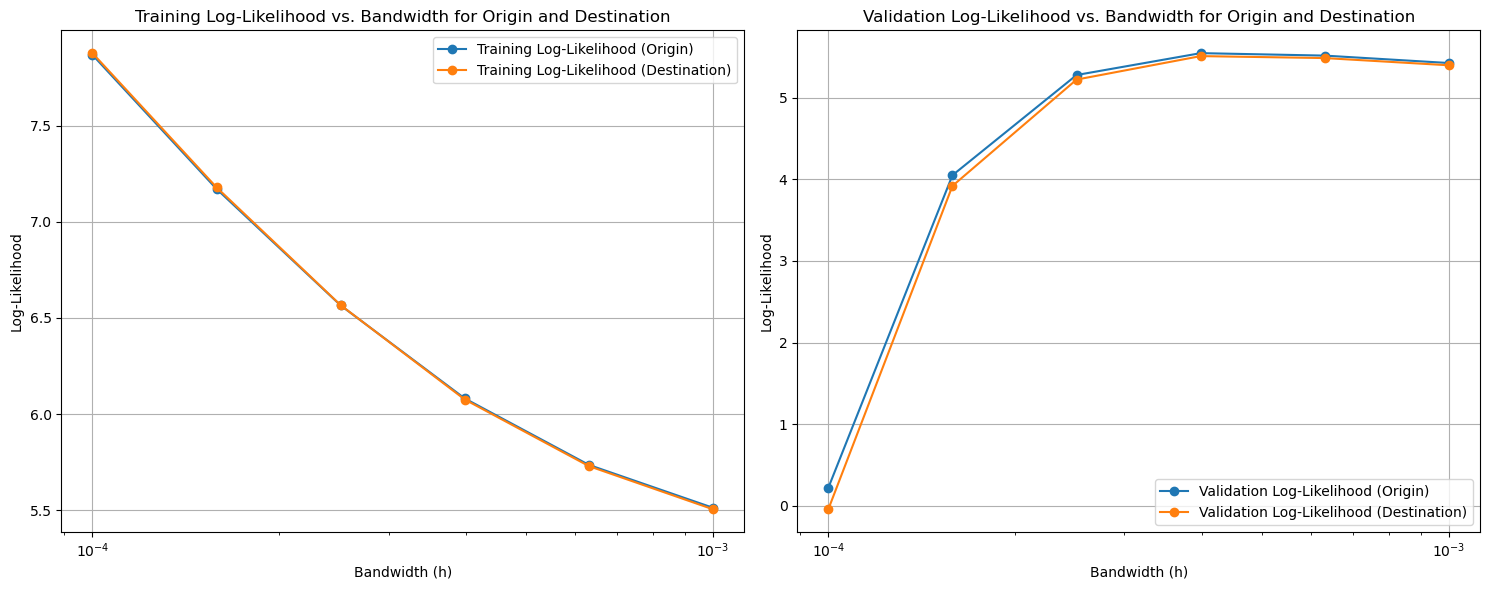

In [24]:
# Create a figure with 1 row and 2 columns for side-by-side plots
plt.figure(figsize=(15, 6))

# First subplot: Training Log-Likelihood
plt.subplot(1, 2, 1)
plt.plot(h_list, logLikelihoodOrigin_train_list, label='Training Log-Likelihood (Origin)', marker='o')
plt.plot(h_list, logLikelihoodDestination_train_list, label='Training Log-Likelihood (Destination)', marker='o')
plt.xscale('log')
plt.xlabel('Bandwidth (h)')
plt.ylabel('Log-Likelihood')
plt.title('Training Log-Likelihood vs. Bandwidth for Origin and Destination')
plt.legend()
plt.grid(True)

# Second subplot: Validation Log-Likelihood
plt.subplot(1, 2, 2)
plt.plot(h_list, logLikelihoodOrigin_valid_list, label='Validation Log-Likelihood (Origin)', marker='o')
plt.plot(h_list, logLikelihoodDestination_valid_list, label='Validation Log-Likelihood (Destination)', marker='o')
plt.xscale('log')
plt.xlabel('Bandwidth (h)')
plt.ylabel('Log-Likelihood')
plt.title('Validation Log-Likelihood vs. Bandwidth for Origin and Destination')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Save the plot as a PNG image
plt.savefig("log_likelihood_plots.png", format='png')

# Show the plot
plt.show()
